PCA after remove the hydrogen descriptor

In [1]:
import pandas as pd
import molli as ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load the Excel files into DataFrames
file1_path = 'molecule_charges_mean_replaced.xlsx'
file2_path = 'sterimol_quadrant_values_with_hydrogen_means.xlsx'

# Read the Excel files into DataFrames
df_charges = pd.read_excel(file1_path)
df_sterimol = pd.read_excel(file2_path)

# Combine the two datasets on the 'Molecule' column using an inner join
combined_df = pd.merge(df_charges, df_sterimol, on='Molecule', how='inner')

# Save the combined dataset to a new Excel file
output_path = 'combined_molecule_data.xlsx'
combined_df.to_excel(output_path, index=False)

# Initialize the Molecule Library to get _Alkene_Type
mlib_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/4_DB_OPT_AlignVol.mlib'
mlib = ml.MoleculeLibrary(mlib_path)

alkene_type_dict = {}

with mlib.reading():
    for k in mlib:
        m = mlib[k]
        alkene_type_dict[m.name] = m.attrib.get('_Alkene_Type', None)

combined_df['_Alkene_Type'] = combined_df['Molecule'].map(alkene_type_dict)

# Save the final output with the _Alkene_Type added
final_combined_output_path = 'combined_molecule_data_with_alkene_type.xlsx'
combined_df.to_excel(final_combined_output_path, index=False)

# Display the DataFrame with _Alkene_Type
print(combined_df.head())


     Molecule  Q1_charge  Q2_charge  Q3_charge  Q4_charge  C1_charge  \
0   react_444      0.987      0.007      0.023   0.063919     -0.134   
1  react_2190      0.508      0.345      0.051   0.063919     -0.072   
2  react_2163      0.461     -0.001      0.051   0.063919     -0.005   
3   react_830      0.026     -0.252      0.342   0.063919      0.084   
4  react_1546     -0.305     -0.149      0.016   0.063919      0.082   

   C2_charge     Q1_B1     Q1_B5      Q1_L     Q2_B1     Q2_B5      Q2_L  \
0      0.019  1.100000  1.100000  2.594888  2.277150  7.342052  6.159241   
1     -0.075  1.100000  1.100000  2.594888  2.100461  5.256847  6.798619   
2     -0.041  1.100000  1.100000  2.594888  2.642201  3.847405  5.374224   
3      0.067  1.702254  3.865122  8.093198  2.096117  3.818156  6.274005   
4      0.051  1.700000  3.892121  7.707303  1.520000  4.931413  6.854829   

      Q3_B1     Q3_B5      Q3_L     Q4_B1     Q4_B5      Q4_L _Alkene_Type  
0  1.701957  4.370192  7.458440  

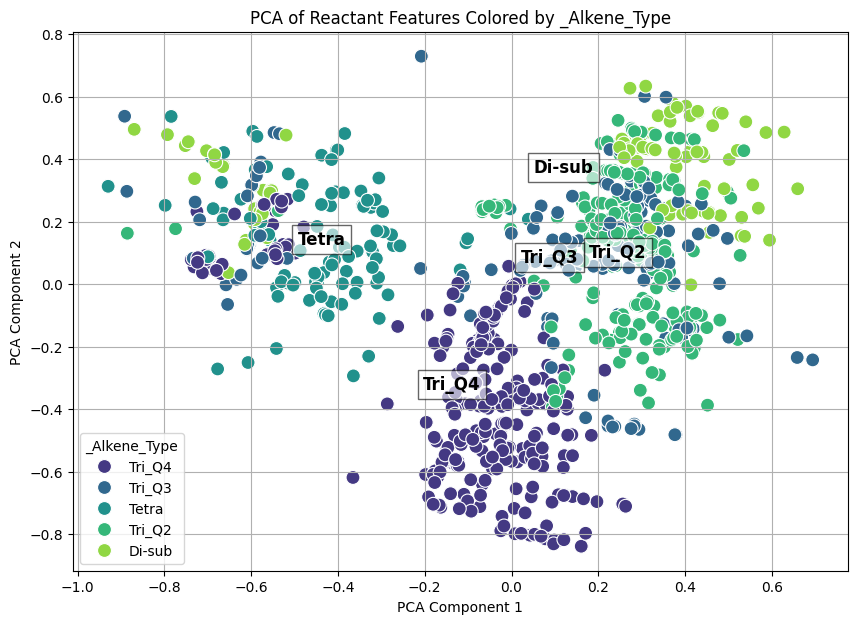

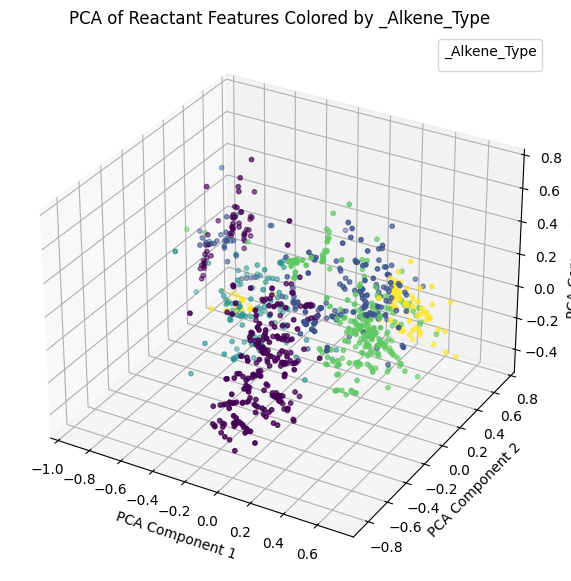

In [2]:
# Load the dataset
file_path = 'combined_molecule_data_with_alkene_type.xlsx'
df = pd.read_excel(file_path)

# Preserve the 'Reaction ID' and '_Alkene_Type' for labeling
labels = df['Molecule']
alkene_types = df['_Alkene_Type']

# Drop irrelevant features and non-numeric columns, but keep '_Alkene_Type'
# df = df.drop(columns=['Rxn ID', 'Pressure/atm', 'Temperature/C', 'S/C', 'ddG'])
# df = df.drop(columns=df.filter(like='C').columns)

# Select only numeric columns
df_numeric = df.select_dtypes(include=[float, int])

# Drop rows with any missing values
df_numeric = df_numeric.dropna()

# Ensure 'alkene_types' aligns with the numeric dataframe
alkene_types = alkene_types[df_numeric.index]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the data
scaler.fit(df_numeric)

# Transform the data using the fitted scaler
df_scaled = pd.DataFrame(scaler.transform(df_numeric), columns=df_numeric.columns)

# Apply VarianceThreshold to remove low-variance features
selector = VarianceThreshold(threshold=0)
df_selected = pd.DataFrame(selector.fit_transform(df_scaled), columns=df_scaled.columns[selector.get_support()])

# Apply PCA to Reactant Features
reactant_features = [col for col in df_selected.columns if 'Q' in col or 'C' in col]
pca_reactants = PCA(n_components=2)
reactant_pca = pca_reactants.fit_transform(df_selected[reactant_features])

# Convert the PCA-transformed features back to a DataFrame
reactant_pca_df = pd.DataFrame(reactant_pca, columns=[f'Reactant_PCA{i+1}' for i in range(reactant_pca.shape[1])])

# Visualization of PCA for Reactant Features colored by _Alkene_Type
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reactant_pca_df['Reactant_PCA1'], 
                y=reactant_pca_df['Reactant_PCA2'], 
                hue=alkene_types, 
                palette='viridis', 
                s=100)

# Calculate centroids for each group (_Alkene_Type)
group_centroids = reactant_pca_df.groupby(alkene_types).mean()

# Annotate each group with its name at the centroid position
for label, centroid in group_centroids.iterrows():
    plt.text(centroid['Reactant_PCA1'], centroid['Reactant_PCA2'], label, 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.6))

plt.title('PCA of Reactant Features Colored by _Alkene_Type')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='_Alkene_Type')
plt.grid(True)
plt.show()


# Load the dataset
file_path = 'combined_molecule_data_with_alkene_type.xlsx'
df = pd.read_excel(file_path)

# Preserve the 'Reaction ID' and '_Alkene_Type' for labeling
labels = df['Molecule']
alkene_types = df['_Alkene_Type']

# Drop irrelevant features and non-numeric columns, but keep '_Alkene_Type'
# Select only numeric columns
df_numeric = df.select_dtypes(include=[float, int])

# Drop rows with any missing values
df_numeric = df_numeric.dropna()

alkene_types = alkene_types[df_numeric.index]

scaler = MinMaxScaler()

scaler.fit(df_numeric)

df_scaled = pd.DataFrame(scaler.transform(df_numeric), columns=df_numeric.columns)

# Apply VarianceThreshold to remove low-variance features
selector = VarianceThreshold(threshold=0)
df_selected = pd.DataFrame(selector.fit_transform(df_scaled), columns=df_scaled.columns[selector.get_support()])

# Apply PCA to Reactant Features with 3 components
reactant_features = [col for col in df_selected.columns if 'Q' in col or 'C' in col]
pca_reactants = PCA(n_components=3)
reactant_pca = pca_reactants.fit_transform(df_selected[reactant_features])

# Convert the PCA-transformed features back to a DataFrame
reactant_pca_df = pd.DataFrame(reactant_pca, columns=[f'Reactant_PCA{i+1}' for i in range(reactant_pca.shape[1])])

# Visualization of PCA for Reactant Features colored by _Alkene_Type in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reactant_pca_df['Reactant_PCA1'], 
                reactant_pca_df['Reactant_PCA2'], 
                reactant_pca_df['Reactant_PCA3'], 
                c=alkene_types.map({label: idx for idx, label in enumerate(alkene_types.unique())}), 
                cmap='viridis', s=10)

ax.set_title('PCA of Reactant Features Colored by _Alkene_Type')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

unique_alkene_types = alkene_types.unique()
handles, _ = sc.legend_elements(prop="colors", alpha=0.6)
legend_labels = [unique_alkene_types[int(h.get_label())] for h in handles if h.get_label().isdigit()]
ax.legend(handles, legend_labels, title="_Alkene_Type")

plt.show()


In [3]:
circled_region_mask = (reactant_pca_df['Reactant_PCA1'] > -1.0) & (reactant_pca_df['Reactant_PCA1'] < -0.3) & \
                      (reactant_pca_df['Reactant_PCA2'] > 0.0) & (reactant_pca_df['Reactant_PCA2'] < 0.5)

# Extract molecule IDs and their alkene types in the circled region
molecules_in_circled_region = labels[circled_region_mask]
alkene_types_in_circled_region = alkene_types[circled_region_mask]

# Create a DataFrame to hold the molecules and their alkene types
circled_region_df = pd.DataFrame({'Molecule': molecules_in_circled_region, '_Alkene_Type': alkene_types_in_circled_region})

# Display the molecules in the circled region grouped by alkene type
print(circled_region_df.groupby('_Alkene_Type').head())


       Molecule _Alkene_Type
3     react_830        Tetra
4    react_1546        Tetra
13   react_2121       Di-sub
16     react_81       Tri_Q4
25   react_2263        Tetra
33   react_2695       Tri_Q4
35   react_2618        Tetra
39      react_3        Tetra
45    react_381       Di-sub
46   react_1932       Tri_Q4
47    react_131       Tri_Q3
50    react_563       Tri_Q3
58    react_892       Tri_Q3
86   react_2206       Tri_Q3
91   react_1357       Tri_Q4
107  react_1694       Tri_Q3
109  react_2396       Di-sub
117   react_840       Tri_Q4
142  react_1622       Di-sub
145   react_236       Di-sub
485   react_853       Tri_Q2
535  react_2215       Tri_Q2
681  react_2591       Tri_Q2


C/C=C(\NC(C)=O)c1ccccc1
C=C(C(=O)O)c1ccccc1
CCO/C(=C\c1ccccc1)C(=O)O
C=C(C(=O)O)c1ccc(F)cc1
CC1=CC(=O)CCC1
CC1=CC(=O)CC1
O=C(C1=C(c2cc(OCc3ccccc3)ccc2OCc2ccccc2)CCC1)c1ccc(OCc2ccccc2)cc1
O=C(C1=C(c2c(OCc3ccccc3)cccc2OCc2ccccc2)CCC1)c1ccccc1
COC(=O)/C=C(\C#N)c1ccc(Br)cc1
C/C(=C\[N+](=O)[O-])c1cccs1
CCOC(=O)/C=C(\Sc1ccccc1)c1cccc(OC)c1
CO/C(=C\c1ccc(F)cc1)C(=O)O
CC(=O)N/C(=C\c1cccs1)C(F)(F)F


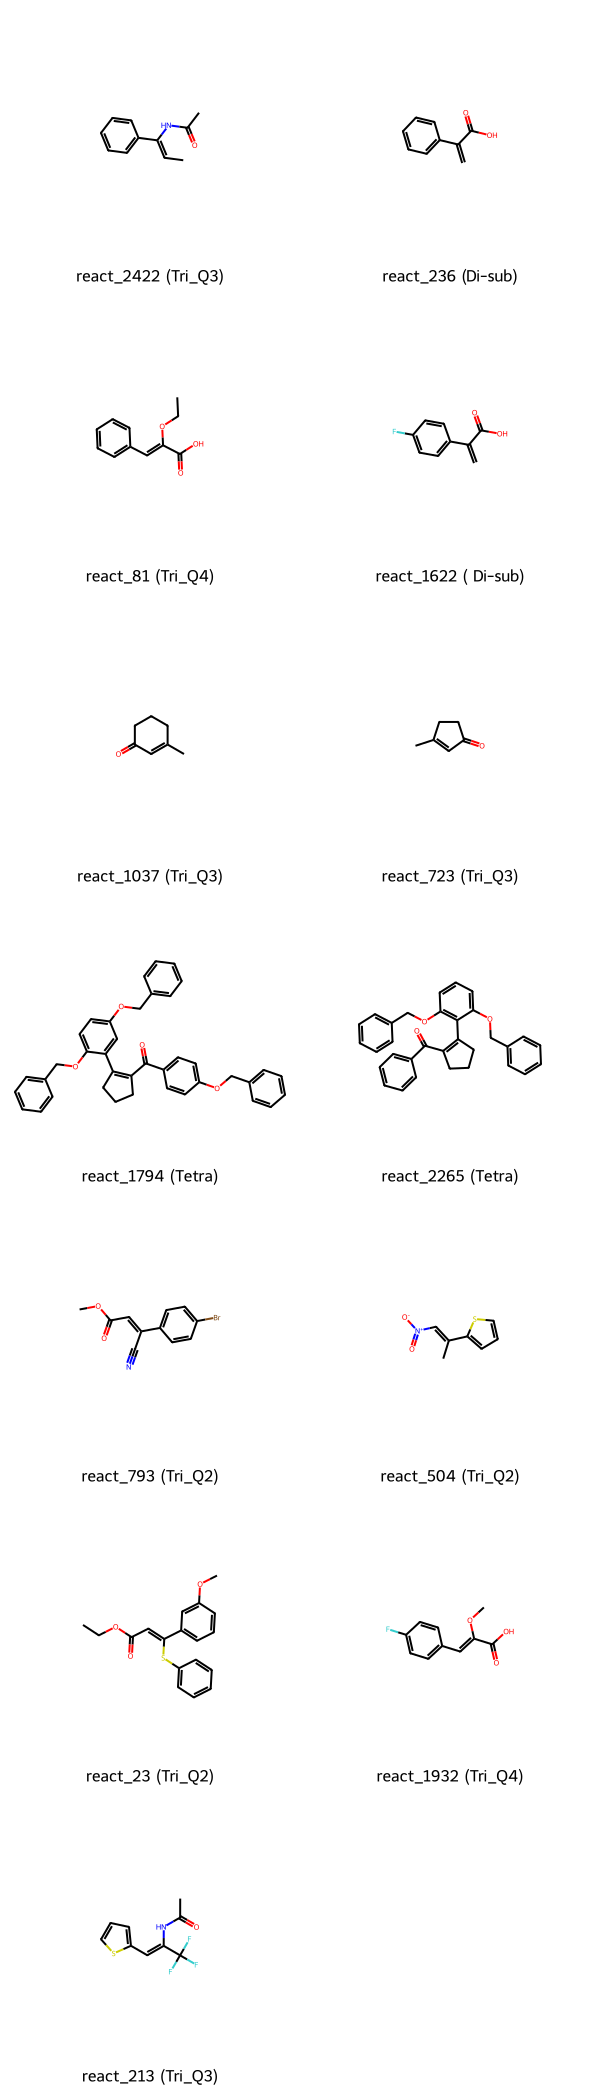

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Load the Excel file containing the Reactant SMILES
file_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/alkene/fixed_react_map_aho_dataset.xlsx'
df = pd.read_excel(file_path)

reactant_ids = ['react_1622', 'react_236', 'react_23', 'react_793', 'react_504', 
                'react_1794', 'react_723', 'react_2422', 'react_2265', 'react_213', 'react_1037', 'react_81', 'react_1932']

# Manually map Reactant IDs to their corresponding _Alkene_Type.
alkene_type_map = {
    'react_1622': ' Di-sub',
    'react_236': 'Di-sub',
    'react_23': 'Tri_Q2',
    'react_793': 'Tri_Q2',
    'react_504': 'Tri_Q2',
    'react_1794': 'Tetra',
    'react_723': 'Tri_Q3',
    'react_2422': 'Tri_Q3',
    'react_2265': 'Tetra',
    'react_213': 'Tri_Q3',
    'react_1037': 'Tri_Q3',
    'react_81' : 'Tri_Q4',
    'react_1932' :'Tri_Q4'
}


# Filter the DataFrame to get rows with the specified Reactant IDs
filtered_df = df[df['Reactant ID'].isin(reactant_ids)]

# Extract unique SMILES strings corresponding to the reactant IDs
unique_smiles_df = filtered_df[['Reactant ID', 'Reactant SMILES']].drop_duplicates(subset='Reactant SMILES')

# Convert SMILES strings to RDKit Mol objects, filtering out any invalid ones
mols = []
valid_legends = []
for index, row in unique_smiles_df.iterrows():
    mol = Chem.MolFromSmiles(row['Reactant SMILES'])
    print(row['Reactant SMILES'])  # Optionally print SMILES for debugging
    if mol is not None:  # Only add if the SMILES was valid
        mols.append(mol)
        # Create a label that includes both the Reactant ID and the manually mapped _Alkene_Type
        legend = f"{row['Reactant ID']} ({alkene_type_map[row['Reactant ID']]})"
        valid_legends.append(legend)

# Visualize the molecules in a grid with both Reactant ID and _Alkene_Type as the legend
if mols:  # Ensure there are molecules to display
    img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300, 300), legends=valid_legends)
    display(img)
else:
    print("No valid molecules to display.")


In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# Load the dataset
file_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/machine_learning/combined_molecule_data_with_alkene_type.xlsx'
df = pd.read_excel(file_path)

# Step 1: Filter the DataFrame for Di-substituted alkenes
di_sub_df = df[df['_Alkene_Type'] == 'Di-sub']

# Step 2: Select only numeric columns
df_numeric = di_sub_df.select_dtypes(include=[float, int])

# Drop rows with any missing values
df_numeric = df_numeric.dropna()

# Step 3: Apply MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Step 4: Apply VarianceThreshold to remove low-variance features
selector = VarianceThreshold(threshold=0)
df_selected = pd.DataFrame(selector.fit_transform(df_scaled), columns=df_scaled.columns[selector.get_support()])

# Step 5: Define 'reactant_features' and exclude Q2 and Q3 (i.e., throw out features related to hydrogens)
reactant_features = [col for col in df_selected.columns if 'Q2' not in col and 'Q3' not in col and ('Q' in col or 'C' in col)]

# Step 6: Apply PCA
pca_reactants_3d = PCA(n_components=3)
reactant_pca_3d = pca_reactants_3d.fit_transform(df_selected[reactant_features])

# Convert the PCA-transformed features back to a DataFrame
reactant_pca_3d_df = pd.DataFrame(reactant_pca_3d, columns=[f'Reactant_PCA{i+1}' for i in range(reactant_pca_3d.shape[1])])

# Step 7: Add the PCA components to the original DataFrame for labeling and grouping
di_sub_df = di_sub_df.reset_index(drop=True)
di_sub_df = pd.concat([di_sub_df, reactant_pca_3d_df], axis=1)

# Step 8: Save the updated dataframe with PCA coordinates for inspection
di_sub_df[['Molecule', 'Reactant_PCA1', 'Reactant_PCA2', 'Reactant_PCA3']].to_excel("di_sub_with_pca_coordinates.xlsx", index=False)

print("Molecules with PCA coordinates saved for inspection.")


Molecules with PCA coordinates saved for inspection.


clustered the 3D PCA of Di-sub 

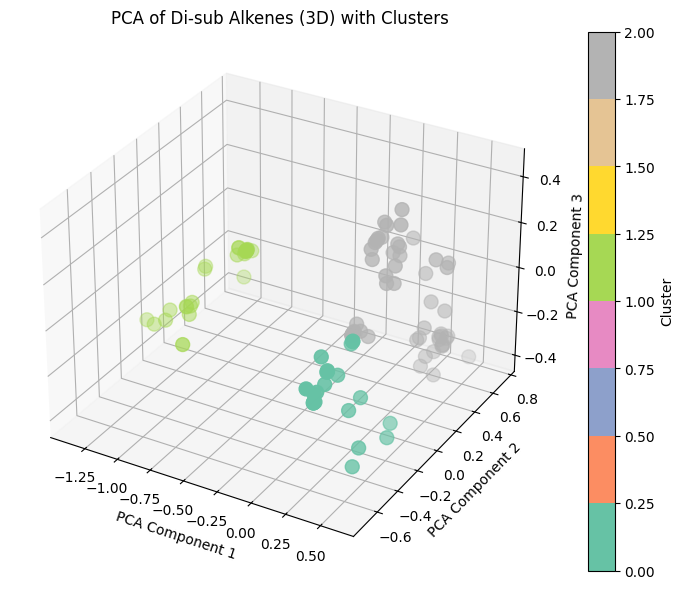

Clusters and PCA coordinates saved.


In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans  # For clustering
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
file_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/machine_learning/combined_molecule_data_with_alkene_type.xlsx'
df = pd.read_excel(file_path)

# Step 1: Filter the DataFrame for Di-substituted alkenes
di_sub_df = df[df['_Alkene_Type'] == 'Di-sub']

# Preserve the 'Molecule' and '_Alkene_Type' for labeling
labels = di_sub_df['Molecule']

# Step 2: Select only numeric columns
df_numeric = di_sub_df.select_dtypes(include=[float, int])

# Drop rows with any missing values
df_numeric = df_numeric.dropna()

# Step 3: Apply MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Step 4: Apply VarianceThreshold to remove low-variance features
selector = VarianceThreshold(threshold=0)
df_selected = pd.DataFrame(selector.fit_transform(df_scaled), columns=df_scaled.columns[selector.get_support()])

# Step 5: Define 'reactant_features' and exclude Q2 and Q3 (hydrogen-related)
reactant_features = [col for col in df_selected.columns if 'Q2' not in col and 'Q3' not in col and ('Q' in col or 'C' in col)]

# Step 6: Apply PCA
pca_reactants_3d = PCA(n_components=3)
reactant_pca_3d = pca_reactants_3d.fit_transform(df_selected[reactant_features])

# Step 7: Apply KMeans clustering (for example, with 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(reactant_pca_3d)

# Step 8: Add the PCA components and cluster labels to the original DataFrame
reactant_pca_3d_df = pd.DataFrame(reactant_pca_3d, columns=[f'Reactant_PCA{i+1}' for i in range(reactant_pca_3d.shape[1])])
di_sub_df = di_sub_df.reset_index(drop=True)
di_sub_df = pd.concat([di_sub_df, reactant_pca_3d_df], axis=1)
di_sub_df['Cluster'] = clusters

# Step 9: 3D Visualization of PCA for Reactant Features colored by clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(di_sub_df['Reactant_PCA1'], 
                di_sub_df['Reactant_PCA2'], 
                di_sub_df['Reactant_PCA3'], 
                c=di_sub_df['Cluster'], 
                cmap='Set2', s=100)

# Add axis labels and title
ax.set_title('PCA of Di-sub Alkenes (3D) with Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Add legend
plt.colorbar(sc, label='Cluster')
plt.show()

# Step 10: Save the updated dataframe with PCA coordinates and clusters for inspection
di_sub_df[['Molecule', 'Cluster', 'Reactant_PCA1', 'Reactant_PCA2', 'Reactant_PCA3']].to_excel("di_sub_with_pca_and_clusters.xlsx", index=False)

print("Clusters and PCA coordinates saved.")


Evaluating distortion for alkene type: Tri_Q4


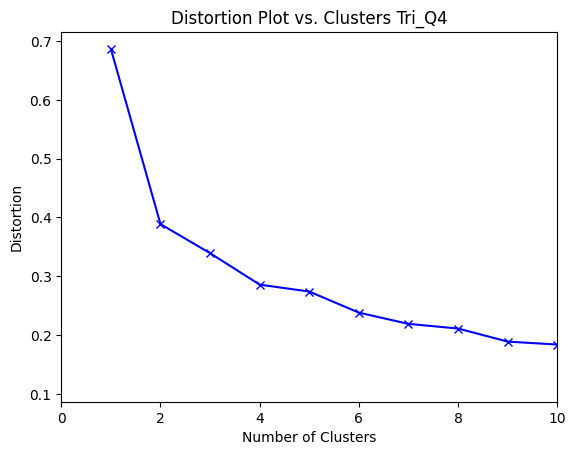

Elbow point for Tri_Q4: 6
Evaluating distortion for alkene type: Tri_Q3


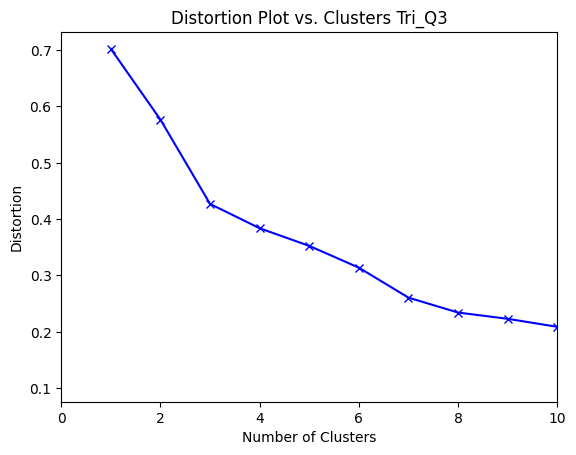

Elbow point for Tri_Q3: 7
Evaluating distortion for alkene type: Tetra


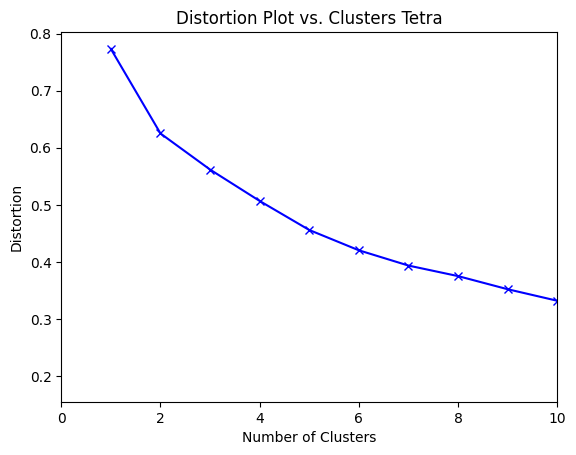

Elbow point for Tetra: 6
Evaluating distortion for alkene type: Tri_Q2


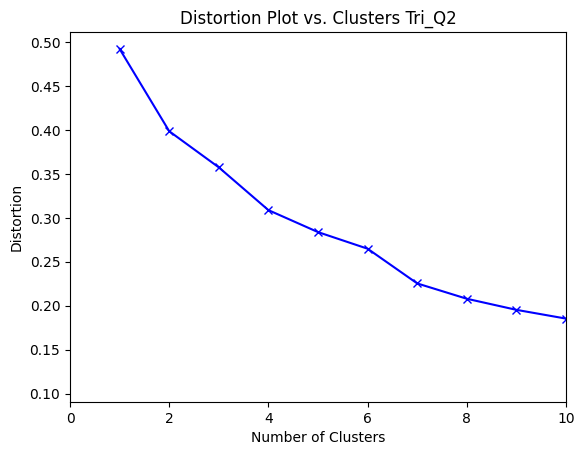

Elbow point for Tri_Q2: 7
Evaluating distortion for alkene type: Di-sub


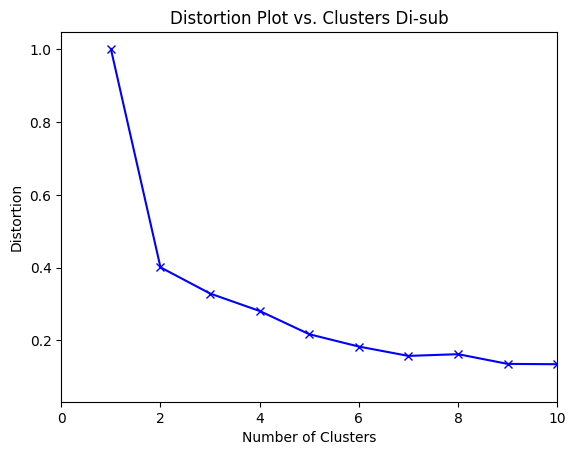

Elbow point for Di-sub: 5
{'Tri_Q4': ['911', '2373', '1428', '606', '19', '881'], 'Tri_Q3': ['1643', '885', '118', '74', '645', '1845', '1661'], 'Tetra': ['695', '409', '289', '403', '830', '556'], 'Tri_Q2': ['238', '1276', '711', '727', '829', '2515', '1056'], 'Di-sub': ['2252', '231', '1997', '1991', '135']}


In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from kneed import KneeLocator
import re  # For cleaning molecule strings
import numpy as np
# Load the dataset
file_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/machine_learning/combined_molecule_data_with_alkene_type.xlsx'
df = pd.read_excel(file_path)

# Define the eval_distortion function
def eval_distortion(full_df: pd.DataFrame, max_clusters=None, name='test', plot_distortion=False):
    distortions = list()
    inertias = list()
    
    K = range(1, max_clusters+1) if max_clusters else range(1, full_df.shape[0]+1)
    
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(full_df)
        distortions.append(sum(np.min(cdist(full_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1) ** 2) / full_df.shape[0])
        inertias.append(kmeanModel.inertia_)
    
    if plot_distortion:
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Distortion')
        plt.xlim(0,10)  # Adjusted axis range
        plt.title(f'Distortion Plot vs. Clusters {name}')
        plt.show()

        # Use kneed to find the elbow point
        kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
        elbow = kl.elbow
        print(f"Elbow point for {name}: {elbow}")
        return elbow

# Dictionary to store alkene types and corresponding Molecules at the elbow point
elbow_molecules = {}

# List of unique alkene types
alkene_types = df['_Alkene_Type'].unique()

for alkene_type in alkene_types:
    # Filter the DataFrame for the current alkene type
    alkene_df = df[df['_Alkene_Type'] == alkene_type]
    
    # Select only numeric columns and store Molecule
    df_numeric = alkene_df.select_dtypes(include=[float, int])
    molecules = alkene_df['Molecule']
    
    # Drop rows with any missing values
    df_numeric = df_numeric.dropna()

    # Apply MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
    
    # Adjust VarianceThreshold for more sensitivity
    selector = VarianceThreshold(threshold=0.01)  # Increased threshold for more aggressive feature selection
    df_selected = pd.DataFrame(selector.fit_transform(df_scaled), columns=df_scaled.columns[selector.get_support()])
    
    # Evaluate distortion and get the elbow point based on the original data (no PCA)
    print(f"Evaluating distortion for alkene type: {alkene_type}")
    elbow = eval_distortion(df_selected, max_clusters=20, name=alkene_type, plot_distortion=True)  # Increased max clusters to 20

    if elbow:
        # Fit KMeans with the number of clusters at the elbow point
        kmeans = KMeans(n_clusters=elbow, random_state=42)
        kmeans.fit(df_selected)
        
        # Find the Molecule of the points closest to the cluster centers
        distances = cdist(kmeans.cluster_centers_, df_selected, 'euclidean')
        closest_indices = distances.argmin(axis=1)
        closest_molecules = alkene_df.iloc[closest_indices]['Molecule'].values
        
        # Store Molecule closest to the cluster centers in a dictionary
        elbow_molecules[alkene_type] = [re.sub(r'\D', '', str(molecule)) for molecule in closest_molecules]

# Output the dictionary
print(elbow_molecules)


Visualizing group: Tri_Q4


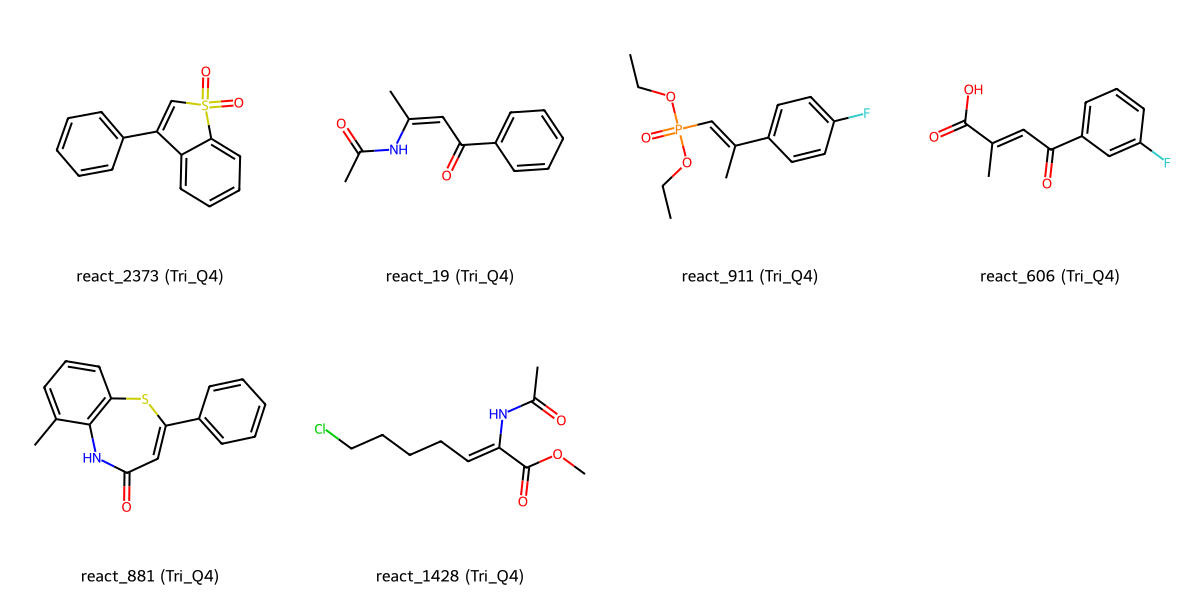

Visualizing group: Tri_Q3


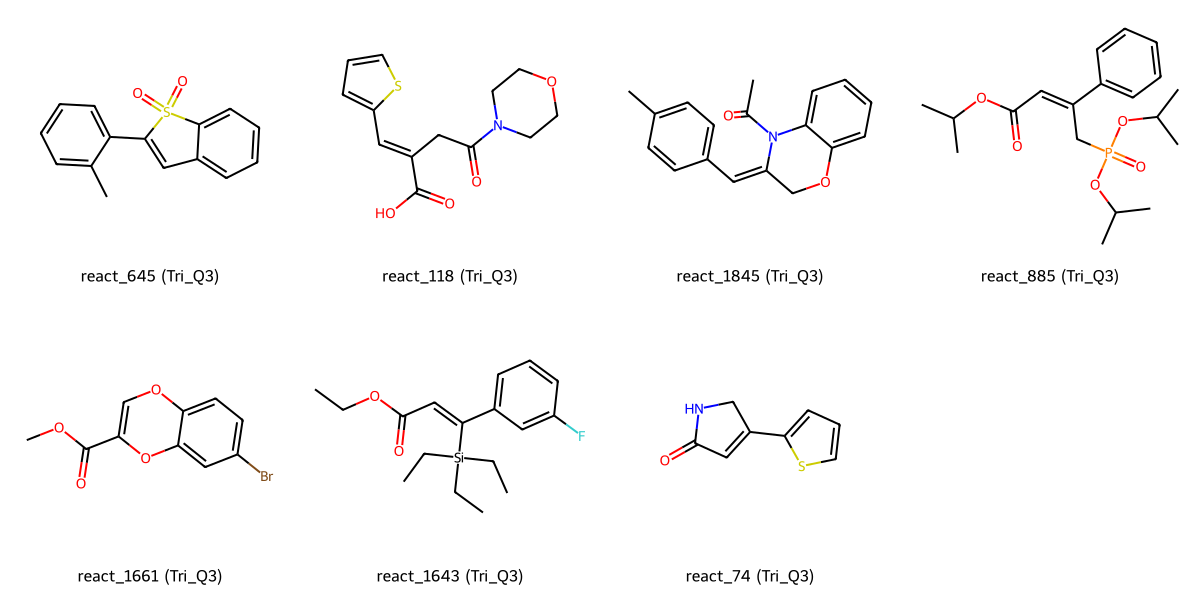

Visualizing group: Tetra


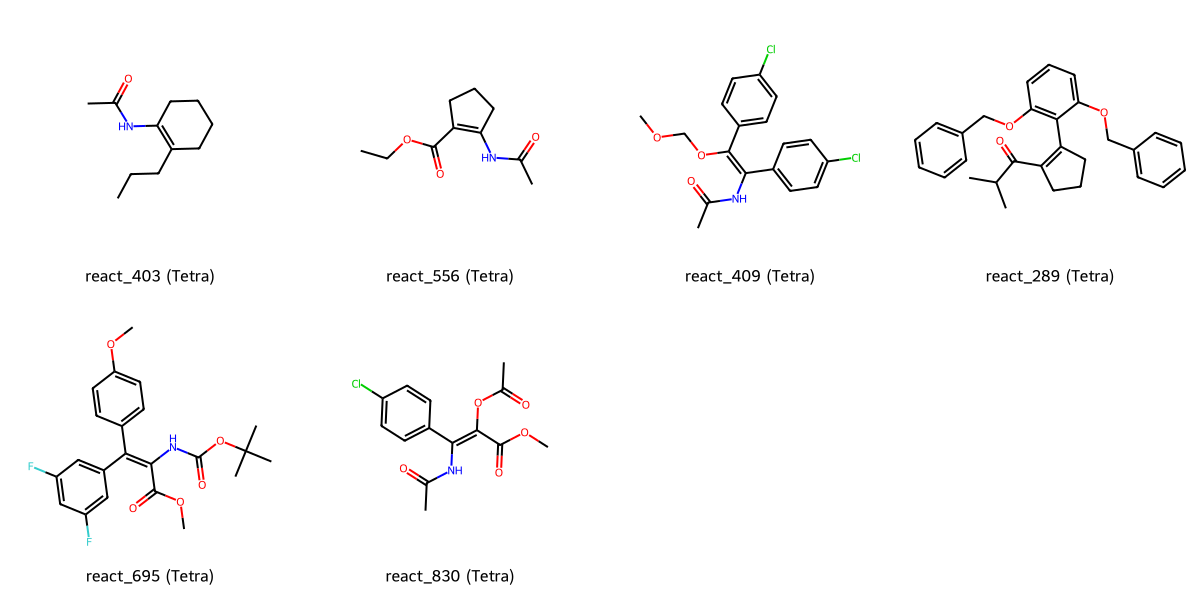

Visualizing group: Tri_Q2


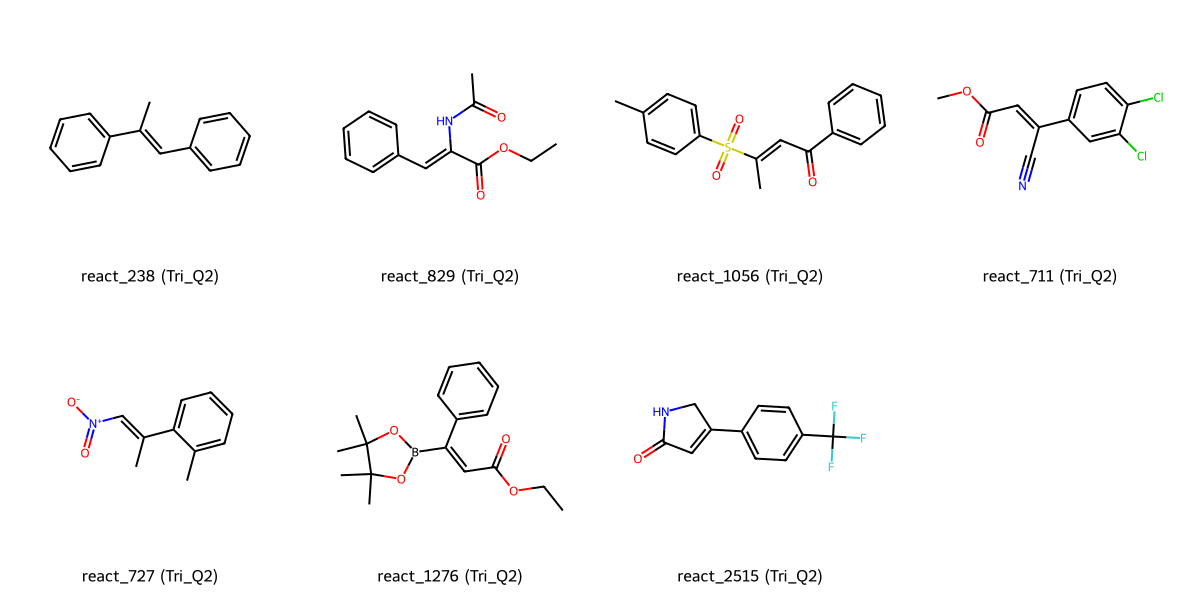

Visualizing group: Di-sub


In [8]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Load the Excel file containing the Reactant SMILES
file_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/alkene/fixed_react_map_aho_dataset.xlsx'
df = pd.read_excel(file_path)

# Your elbow_molecules dictionary
elbow_molecules = {
    'Tri_Q4': ['react_911', 'react_2373', 'react_1428', 'react_606', 'react_19', 'react_881'],
    'Tri_Q3': ['react_1643', 'react_885', 'react_118', 'react_74', 'react_645', 'react_1845', 'react_1661'],
    'Tetra': ['react_695', 'react_409', 'react_289', 'react_403', 'react_830', 'react_556'],
    'Tri_Q2': ['react_238', 'react_1276', 'react_711', 'react_727', 'react_829', 'react_2515', 'react_1056'],
    'Di-sub': ['react_2252', 'react_231', 'react_1997', 'react_1991', 'react_135']
}


# Function to visualize molecules for a specific group
def visualize_group(group_name, group_ids):
    # Flatten the dictionary to map Reactant IDs to their corresponding _Alkene_Type
    reactant_ids = []
    alkene_type_map = {}
    for reactant_id in group_ids:
        reactant_ids.append(reactant_id)
        alkene_type_map[reactant_id] = group_name

    # Filter the DataFrame to get rows with the specified Reactant IDs
    filtered_df = df[df['Reactant ID'].isin(reactant_ids)]

    # Extract unique SMILES strings corresponding to the reactant IDs
    unique_smiles_df = filtered_df[['Reactant ID', 'Reactant SMILES']].drop_duplicates(subset='Reactant SMILES')

    # Convert SMILES strings to RDKit Mol objects, filtering out any invalid ones
    mols = []
    valid_legends = []
    for index, row in unique_smiles_df.iterrows():
        mol = Chem.MolFromSmiles(row['Reactant SMILES'])
        if mol is not None:  # Only add if the SMILES was valid
            mols.append(mol)
            # Create a label that includes both the Reactant ID and the corresponding _Alkene_Type
            legend = f"{row['Reactant ID']} ({alkene_type_map[row['Reactant ID']]})"
            valid_legends.append(legend)

    # Visualize the molecules in a grid with both Reactant ID and _Alkene_Type as the legend
    if mols:  # Ensure there are molecules to display
        print(f"Visualizing group: {group_name}")
        img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300, 300), legends=valid_legends)
        display(img)
    else:
        print(f"No valid molecules to display for group: {group_name}")

# Loop over each group in elbow_molecules and visualize separately
for group_name, group_ids in elbow_molecules.items():
    visualize_group(group_name, group_ids)


visualize the centroid of each cluster

Processing alkene type: Di-sub with 5 clusters
Visualizing group: Di-sub


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_11495/2168749787.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(reactant_pca_3d_df)


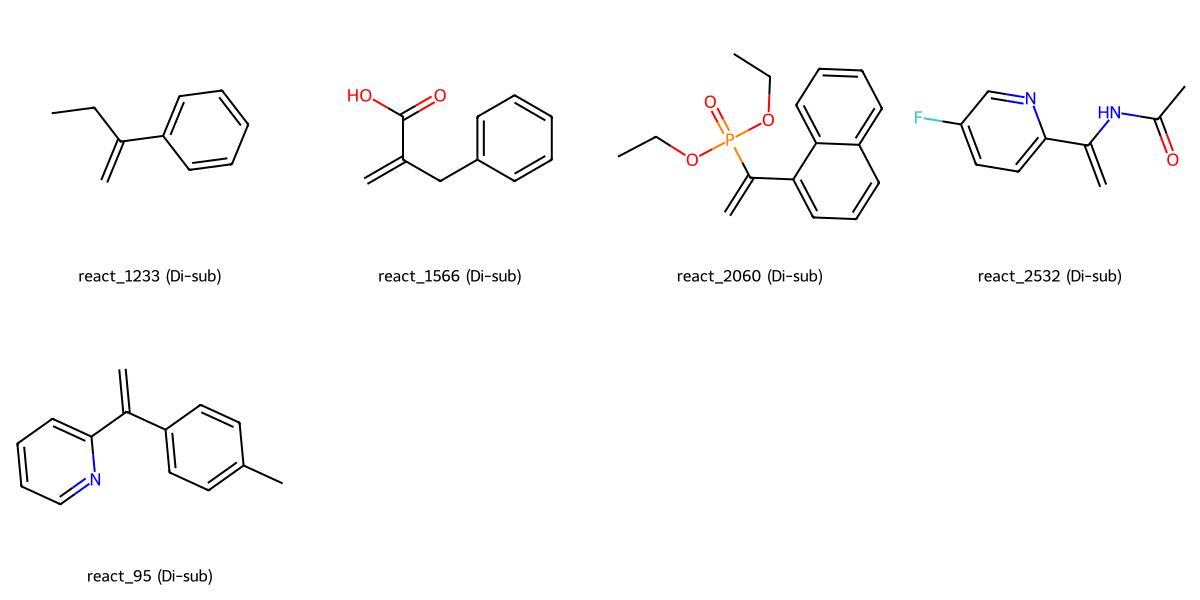

Processing alkene type: Tri_Q2 with 7 clusters
Visualizing group: Tri_Q2


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_11495/2168749787.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(reactant_pca_3d_df)


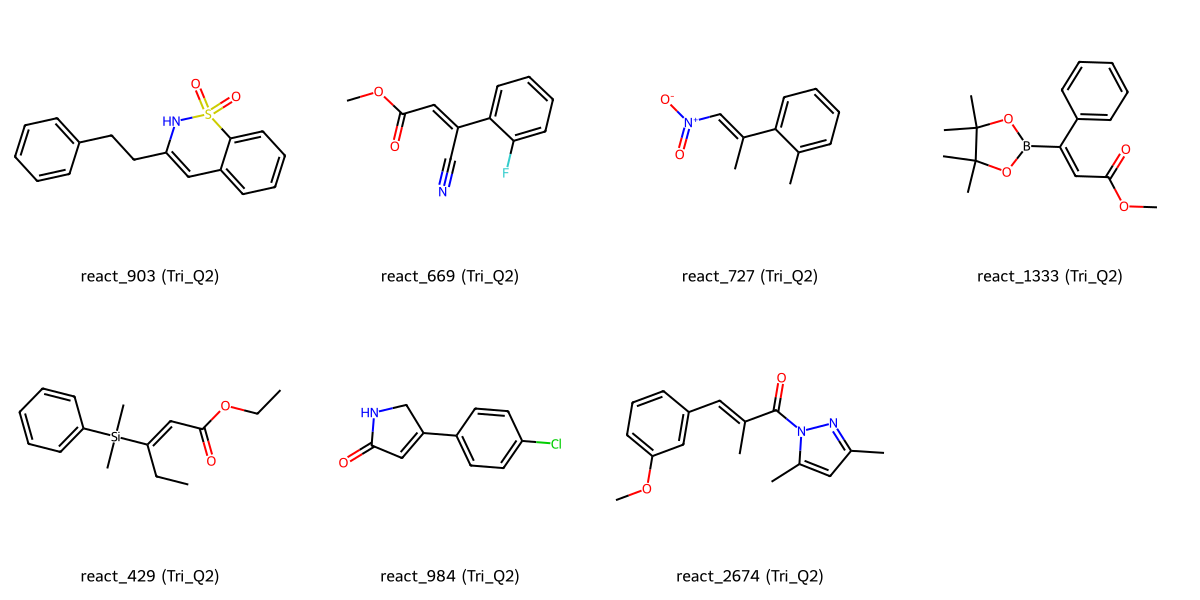

Processing alkene type: Tetra with 6 clusters
Visualizing group: Tetra


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_11495/2168749787.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(reactant_pca_3d_df)


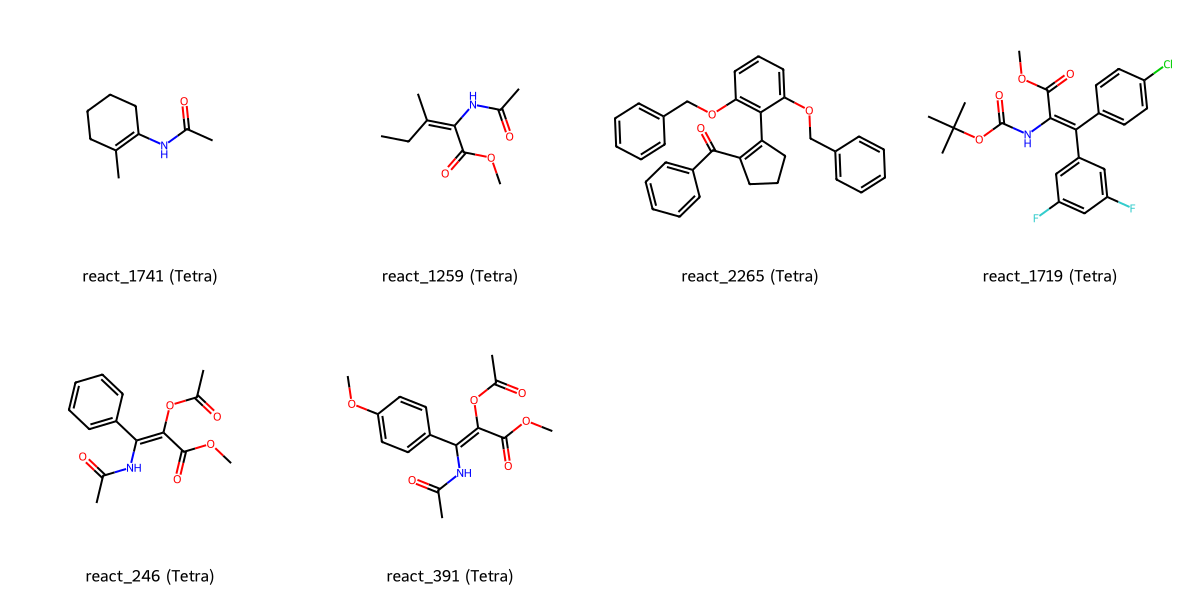

Processing alkene type: Tri_Q3 with 7 clusters
Visualizing group: Tri_Q3


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_11495/2168749787.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(reactant_pca_3d_df)


Processing alkene type: Tri_Q4 with 6 clusters
Visualizing group: Tri_Q4


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_11495/2168749787.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(reactant_pca_3d_df)


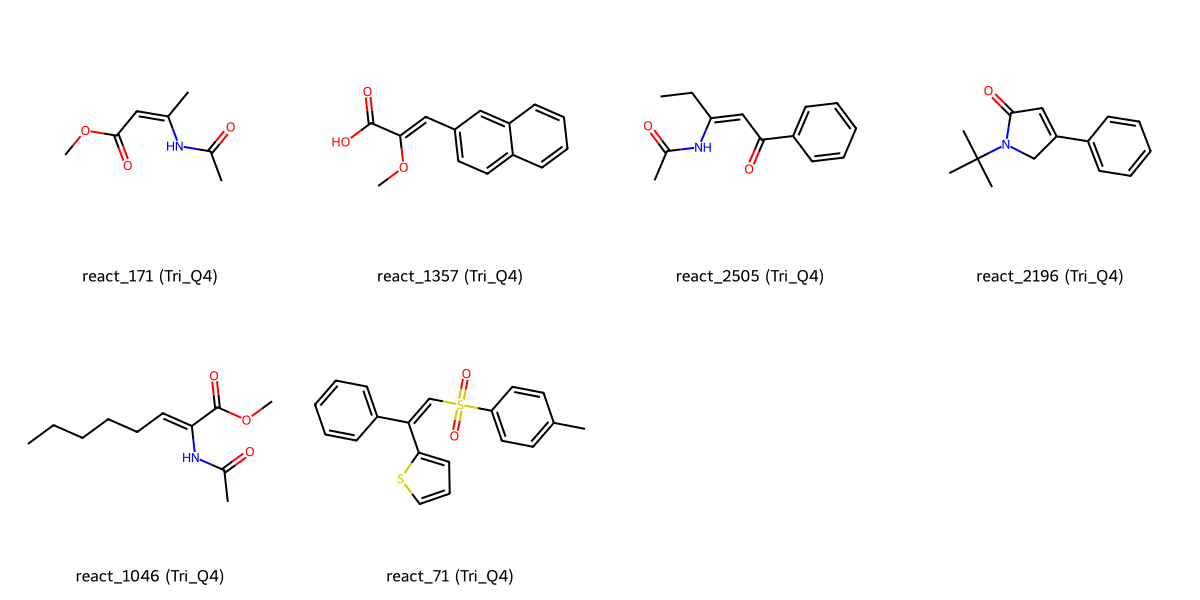

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Load the dataset with Reactant SMILES and IDs
file_path_smiles = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/alkene/fixed_react_map_aho_dataset.xlsx'
df_smiles = pd.read_excel(file_path_smiles)

# Load the dataset for PCA and clustering
file_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/machine_learning/combined_molecule_data_with_alkene_type.xlsx'
df = pd.read_excel(file_path)

# Define the alkene types and their respective elbow points (clusters)
alkene_cluster_map = {
    'Di-sub': 5,
    'Tri_Q2': 7,
    'Tetra': 6,
    'Tri_Q3': 7,
    'Tri_Q4': 6
}

# Function to visualize molecules for a specific group
def visualize_molecules(reactant_ids, group_name):
    # Filter the DataFrame to get rows with the specified Reactant IDs
    filtered_df = df_smiles[df_smiles['Reactant ID'].isin(reactant_ids)]

    # Extract unique SMILES strings corresponding to the reactant IDs
    unique_smiles_df = filtered_df[['Reactant ID', 'Reactant SMILES']].drop_duplicates(subset='Reactant SMILES')

    # Convert SMILES strings to RDKit Mol objects, filtering out any invalid ones
    mols = []
    valid_legends = []
    for index, row in unique_smiles_df.iterrows():
        mol = Chem.MolFromSmiles(row['Reactant SMILES'])
        if mol is not None:  # Only add if the SMILES was valid
            mols.append(mol)
            # Create a label that includes both the Reactant ID and the corresponding _Alkene_Type
            legend = f"{row['Reactant ID']} ({group_name})"
            valid_legends.append(legend)

    # Visualize the molecules in a grid with both Reactant ID and _Alkene_Type as the legend
    if mols:  # Ensure there are molecules to display
        print(f"Visualizing group: {group_name}")
        img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300, 300), legends=valid_legends)
        display(img)
    else:
        print(f"No valid molecules to display for group: {group_name}")

# Iterate over each alkene type and find the molecules closest to the centroids
for alkene_type, n_clusters in alkene_cluster_map.items():
    print(f"Processing alkene type: {alkene_type} with {n_clusters} clusters")
    
    # Step 1: Filter the DataFrame for the current alkene type
    alkene_df = df[df['_Alkene_Type'] == alkene_type]

    # Step 2: Select only numeric columns
    df_numeric = alkene_df.select_dtypes(include=[float, int])

    # Drop rows with any missing values
    df_numeric = df_numeric.dropna()

    # Step 3: Apply MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

    # Step 4: Apply VarianceThreshold to remove low-variance features
    selector = VarianceThreshold(threshold=0)
    df_selected = pd.DataFrame(selector.fit_transform(df_scaled), columns=df_scaled.columns[selector.get_support()])

    # Step 5: Define 'reactant_features' and exclude Q2 and Q3 (optional, if necessary)
    reactant_features = [col for col in df_selected.columns if 'Q2' not in col and 'Q3' not in col and ('Q' in col or 'C' in col)]

    # Step 6: Apply PCA to reduce the dimensions to 3 components
    pca_reactants_3d = PCA(n_components=3)
    reactant_pca_3d = pca_reactants_3d.fit_transform(df_selected[reactant_features])

    # Convert the PCA-transformed features back to a DataFrame
    reactant_pca_3d_df = pd.DataFrame(reactant_pca_3d, columns=[f'Reactant_PCA{i+1}' for i in range(reactant_pca_3d.shape[1])])

    # Step 7: Apply KMeans clustering based on the elbow point for this alkene type
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    alkene_df['Cluster'] = kmeans.fit_predict(reactant_pca_3d_df)

    # Compute the centroids of each cluster
    centroids = kmeans.cluster_centers_

    # Find the molecules closest to each centroid
    distances = cdist(centroids, reactant_pca_3d_df, 'euclidean')
    closest_indices = distances.argmin(axis=1)

    # Get the Reactant IDs closest to the centroids
    closest_molecules = alkene_df.iloc[closest_indices]['Molecule'].values

    # Step 8: Visualize the molecules closest to the centroids
    visualize_molecules(closest_molecules, alkene_type)


visualize the pca of tri_q4 (cluster 1)

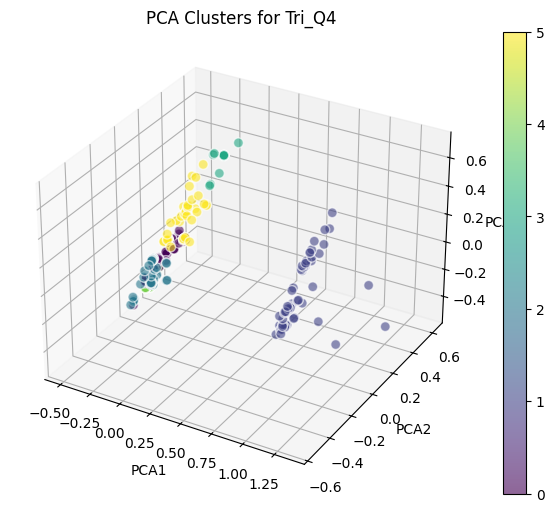

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Visualize the clusters in PCA space
def plot_pca_clusters(pca_df, clusters, alkene_type):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        pca_df['Reactant_PCA1'], pca_df['Reactant_PCA2'], pca_df['Reactant_PCA3'], 
        c=clusters, cmap='viridis', s=50, alpha=0.6, edgecolors='w'
    )

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')

    plt.title(f"PCA Clusters for {alkene_type}")
    plt.colorbar(scatter, ax=ax)
    plt.show()

# Plot the clusters for Tri_Q4
plot_pca_clusters(reactant_pca_3d_df, alkene_df['Cluster'], alkene_type)


# Function to visualize molecules for a specific group
def visualize_group(group_name, group_ids):
    # Load the Excel file containing the Reactant SMILES
    file_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/alkene/fixed_react_map_aho_dataset.xlsx'
    df = pd.read_excel(file_path)

    # Flatten the dictionary to map Reactant IDs to their corresponding group
    reactant_ids = []
    alkene_type_map = {}
    for reactant_id in group_ids:
        reactant_ids.append(reactant_id)
        alkene_type_map[reactant_id] = group_name

    # Filter the DataFrame to get rows with the specified Reactant IDs
    filtered_df = df[df['Reactant ID'].isin(reactant_ids)]

    # Extract unique SMILES strings corresponding to the reactant IDs
    unique_smiles_df = filtered_df[['Reactant ID', 'Reactant SMILES']].drop_duplicates(subset='Reactant SMILES')

    # Convert SMILES strings to RDKit Mol objects, filtering out any invalid ones
    mols = []
    valid_legends = []
    for index, row in unique_smiles_df.iterrows():
        mol = Chem.MolFromSmiles(row['Reactant SMILES'])
        if mol is not None:  # Only add if the SMILES was valid
            mols.append(mol)
            # Create a label that includes both the Reactant ID and the corresponding group name
            legend = f"{row['Reactant ID']} ({alkene_type_map[row['Reactant ID']]})"
            valid_legends.append(legend)

    # Visualize the molecules in a grid with both Reactant ID and group as the legend
    if mols:  # Ensure there are molecules to display
        print(f"Visualizing group: {group_name}")
        img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300, 300), legends=valid_legends)
        display(img)
    else:
        print(f"No valid molecules to display for group: {group_name}")



check the correlation and remove the most related correlation

In [11]:
import seaborn as sns

alkene_df['Cluster'] = alkene_df['Cluster'].astype(float)  # Ensure 'Cluster' is numeric
numeric_columns = alkene_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix for numeric data including 'Cluster'
corr_matrix = numeric_columns.corr()

# Visualize the correlation matrix including 'Cluster'
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix (Including Cluster)')
plt.show()

cluster_correlation = corr_matrix['Cluster'].sort_values(ascending=False)
print("Correlation with Cluster:\n", cluster_correlation)

corr_threshold = 0.2
high_corr_with_cluster = cluster_correlation[cluster_correlation.abs() > corr_threshold].index.tolist()
print(f"Highly correlated features with 'Cluster' (threshold = {corr_threshold}): {high_corr_with_cluster}")



/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_11495/1147296352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = alkene_df['Cluster'].astype(float)  # Ensure 'Cluster' is numeric


Correlation with Cluster:
 Cluster      1.000000
Q2_B5        0.396562
Q4_B5        0.320859
Q3_B1        0.235481
Q2_L         0.195682
Q3_B5        0.168050
Q3_L         0.130725
C2_charge    0.125916
Q1_charge    0.117982
Q2_B1        0.028386
Q4_L        -0.001194
Q2_charge   -0.018742
Q3_charge   -0.133076
Q4_B1       -0.168220
C1_charge   -0.219695
Q1_B5       -0.297931
Q1_L        -0.299956
Q1_B1       -0.302420
Q4_charge         NaN
Name: Cluster, dtype: float64
Highly correlated features with 'Cluster' (threshold = 0.2): ['Cluster', 'Q2_B5', 'Q4_B5', 'Q3_B1', 'C1_charge', 'Q1_B5', 'Q1_L', 'Q1_B1']


Plot the pca by removing the correlated feactures, don't see a signficant change from the previous pca plot

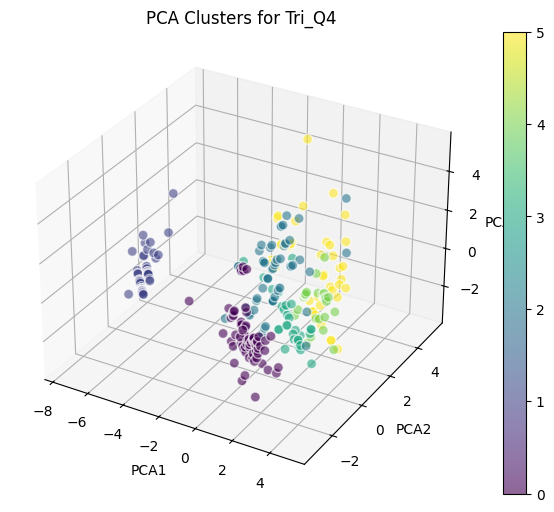

In [12]:
alkene_df_filtered = alkene_df.drop(columns=[ 'Q2_B5', 'Q4_B5', 'Q3_B1', 'C1_charge'])

# Select only numeric columns again, now without the two removed features
numeric_columns_filtered = alkene_df_filtered.select_dtypes(include=[np.number])

def perform_pca(df_selected):
    pca = PCA(n_components=3)  # Reduce to 3 components for 3D visualization
    pca_result = pca.fit_transform(df_selected)
    pca_df = pd.DataFrame(pca_result, columns=['Reactant_PCA1', 'Reactant_PCA2', 'Reactant_PCA3'])
    return pca_df

# Perform PCA on the filtered data (after removing the highly correlated features)
reactant_pca_3d_df_filtered = perform_pca(numeric_columns_filtered)

plot_pca_clusters(reactant_pca_3d_df_filtered, alkene_df['Cluster'], "Tri_Q4")

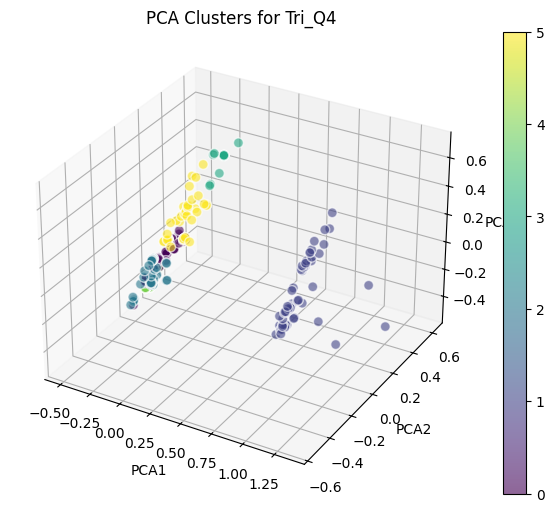

KeyError: 'Molecule'

In [13]:
import pandas as pd
from scipy.spatial.distance import euclidean
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot PCA clusters
def plot_pca_clusters(pca_df, clusters, alkene_type):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        pca_df['Reactant_PCA1'], pca_df['Reactant_PCA2'], pca_df['Reactant_PCA3'], 
        c=clusters, cmap='viridis', s=50, alpha=0.6, edgecolors='w'
    )

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')

    plt.title(f"PCA Clusters for {alkene_type}")
    plt.colorbar(scatter, ax=ax)
    plt.show()

# Plot the clusters for Tri_Q4
plot_pca_clusters(reactant_pca_3d_df, alkene_df['Cluster'], alkene_type)


# Function to calculate distances and visualize closest molecules
def calculate_distances_and_visualize(reactant_pca_3d_df, alkene_df, centroid_of_interest, file_path, group_name):
    # Extract the cluster of interest (assuming cluster 1 is the right one)
    cluster_of_interest = 1
    cluster_df = alkene_df[alkene_df['Cluster'] == cluster_of_interest]

    # Ensure consistent indexing by resetting index if necessary
    cluster_df = cluster_df.reset_index(drop=True)

    # Adjusting the Molecule ID format in the PCA data to match the cluster_df
    # If necessary, add or remove 'react_' prefix to match your dataset formats
    reactant_pca_3d_df['Molecule'] = 'react_' + reactant_pca_3d_df['Molecule'].astype(str)
    reactant_pca_3d_df.set_index('Molecule', inplace=True)

    # Check if we have molecules in cluster 1
    if cluster_df.empty:
        print(f"No molecules found in Cluster {cluster_of_interest}")
        return

    molecule_ids = cluster_df['Molecule'].unique()  # Ensure unique molecule IDs

    # Calculate distances from the centroid to all molecules in cluster 1 using Molecule ID for lookup
    distances_to_centroid = []
    for mol_id in molecule_ids:
        if mol_id in reactant_pca_3d_df.index:
            # Calculate distance from centroid to each molecule
            dist = euclidean(centroid_of_interest, reactant_pca_3d_df.loc[mol_id])
            distances_to_centroid.append((mol_id, dist))

    # Sort distances by the closest molecules
    sorted_distances = sorted(distances_to_centroid, key=lambda x: x[1])

    # Get the 10-15 closest molecules
    closest_molecules = [mol_id for mol_id, dist in sorted_distances[:15]]

    # If no valid molecules are found
    if not closest_molecules:
        print(f"No valid molecules found close to centroid for Cluster {cluster_of_interest}")
        return

    print(f"Closest 10-15 molecules to the centroid of Cluster {cluster_of_interest}:")
    print(closest_molecules)

    # Visualize the closest molecules
    visualize_group(group_name, closest_molecules, file_path)


# Function to visualize molecules for a specific group
def visualize_group(group_name, group_ids, file_path):
    # Load the Excel file containing the Reactant SMILES
    df = pd.read_excel(file_path)

    # Flatten the dictionary to map Reactant IDs to their corresponding group
    reactant_ids = []
    alkene_type_map = {}
    for reactant_id in group_ids:
        reactant_ids.append(reactant_id)
        alkene_type_map[reactant_id] = group_name

    # Filter the DataFrame to get rows with the specified Reactant IDs
    filtered_df = df[df['Reactant ID'].isin(reactant_ids)]

    # Extract unique SMILES strings corresponding to the reactant IDs
    unique_smiles_df = filtered_df[['Reactant ID', 'Reactant SMILES']].drop_duplicates(subset='Reactant SMILES')

    # Convert SMILES strings to RDKit Mol objects, filtering out any invalid ones
    mols = []
    valid_legends = []
    for index, row in unique_smiles_df.iterrows():
        mol = Chem.MolFromSmiles(row['Reactant SMILES'])
        if mol is not None:  # Only add if the SMILES was valid
            mols.append(mol)
            # Create a label that includes both the Reactant ID and the corresponding group name
            legend = f"{row['Reactant ID']} ({group_name})"
            valid_legends.append(legend)

    # Visualize the molecules in a grid with both Reactant ID and group as the legend
    if mols:  # Ensure there are molecules to display
        print(f"Visualizing group: {group_name}")
        img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300, 300), legends=valid_legends)
        display(img)
    else:
        print(f"No valid molecules to display for group: {group_name}")


# Set the centroid (from the k-means result) for the cluster of interest
centroid_of_interest = kmeans.cluster_centers_[1]  # Assuming you want Cluster 1's centroid

# Provide the path to your Excel file with reactant data
file_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/alkene/fixed_react_map_aho_dataset.xlsx'

# Call the function to calculate distances and visualize closest molecules
calculate_distances_and_visualize(reactant_pca_3d_df, alkene_df, centroid_of_interest, file_path, "Cluster 1")


In [ ]:
# Check for column names in the DataFrames
print("Columns in reactant_pca_3d_df:", reactant_pca_3d_df.columns)
print("Columns in alkene_df:", alkene_df.columns)

# Ensure that the Molecule column exists in both DataFrames
if 'Molecule' not in reactant_pca_3d_df.columns:
    print("'Molecule' column not found in reactant_pca_3d_df. Assigning from alkene_df if available.")
    # If reactant_pca_3d_df is missing Molecule, assign it from alkene_df
    if 'Molecule' in alkene_df.columns:
        reactant_pca_3d_df['Molecule'] = alkene_df['Molecule']
    else:
        print("No 'Molecule' column found in alkene_df either. Ensure proper identifier.")
    
if 'Molecule' not in alkene_df.columns:
    print("'Molecule' column not found in alkene_df. Checking for alternative identifiers.")
    # Try renaming an equivalent identifier column in alkene_df
    if 'Reactant ID' in alkene_df.columns:
        alkene_df.rename(columns={'Reactant ID': 'Molecule'}, inplace=True)
        print("Renamed 'Reactant ID' to 'Molecule' in alkene_df.")
    else:
        print("No equivalent identifier found in alkene_df. Please check the dataset.")

# Debugging: Print the first few rows to inspect
print("First few rows of reactant_pca_3d_df:")
print(reactant_pca_3d_df.head())

print("First few rows of alkene_df:")
print(alkene_df.head())


Columns in reactant_pca_3d_df: Index(['Reactant_PCA1', 'Reactant_PCA2', 'Reactant_PCA3'], dtype='object')
Columns in alkene_df: Index(['Molecule', 'Q1_charge', 'Q2_charge', 'Q3_charge', 'Q4_charge',
       'C1_charge', 'C2_charge', 'Q1_B1', 'Q1_B5', 'Q1_L', 'Q2_B1', 'Q2_B5',
       'Q2_L', 'Q3_B1', 'Q3_B5', 'Q3_L', 'Q4_B1', 'Q4_B5', 'Q4_L',
       '_Alkene_Type', 'Cluster'],
      dtype='object')
'Molecule' column not found in reactant_pca_3d_df. Assigning from alkene_df if available.
First few rows of reactant_pca_3d_df:
   Reactant_PCA1  Reactant_PCA2  Reactant_PCA3   Molecule
0      -0.238163       0.541746       0.324791  react_444
1      -0.398562       0.036506      -0.338308        NaN
2      -0.181511      -0.316107      -0.130205        NaN
3       0.682710       0.061159      -0.392335        NaN
4       0.092391      -0.108269       0.597307        NaN
First few rows of alkene_df:
      Molecule  Q1_charge  Q2_charge  Q3_charge  Q4_charge  C1_charge  \
0    react_444      0.

In [ ]:
if len(reactant_pca_3d_df) == len(alkene_df):
    reactant_pca_3d_df['Molecule'] = alkene_df['Molecule'].values
    print("Assigned Molecule values from alkene_df to reactant_pca_3d_df.")
else:
    print("Mismatch in row counts between reactant_pca_3d_df and alkene_df. Ensure proper alignment.")
    
# Debug: Print to ensure the Molecule column has been populated
print(reactant_pca_3d_df[['Reactant_PCA1', 'Reactant_PCA2', 'Reactant_PCA3', 'Molecule']].head())

# After ensuring the Molecule IDs are properly assigned, proceed with the rest of the distance calculation and visualization
# Assuming the rest of the process is correct for the analysis
calculate_distances_and_visualize(reactant_pca_3d_df, alkene_df, centroid_of_interest, file_path, "Cluster 1")


Assigned Molecule values from alkene_df to reactant_pca_3d_df.
          Reactant_PCA1  Reactant_PCA2  Reactant_PCA3    Molecule
Molecule                                                         
NaN           -0.238163       0.541746       0.324791   react_444
NaN           -0.398562       0.036506      -0.338308   react_983
NaN           -0.181511      -0.316107      -0.130205  react_2242
NaN            0.682710       0.061159      -0.392335    react_81
NaN            0.092391      -0.108269       0.597307  react_1101
No valid molecules found close to centroid for Cluster 1


###Visualize the Molecules that's close to the centroid of Tri_Q4 cluster 1(isolated from other clusters)###

Assigned Molecule values from alkene_df to reactant_pca_3d_df.
Molecule set as index in reactant_pca_3d_df.
First few rows of reactant_pca_3d_df with Molecule as index:
            Reactant_PCA1  Reactant_PCA2  Reactant_PCA3
Molecule                                               
react_444       -0.238163       0.541746       0.324791
react_983       -0.398562       0.036506      -0.338308
react_2242      -0.181511      -0.316107      -0.130205
react_81         0.682710       0.061159      -0.392335
react_1101       0.092391      -0.108269       0.597307
Molecule IDs from cluster_df (Cluster 1):
16       react_81
33     react_2695
46     react_1932
91     react_1357
117     react_840
Name: Molecule, dtype: object
Closest 10-15 molecules to the centroid of Cluster 1:
['react_1357', 'react_473', 'react_2115', 'react_47', 'react_508', 'react_2337', 'react_200', 'react_2479', 'react_950', 'react_2460', 'react_2470', 'react_1401', 'react_1137', 'react_618', 'react_2542']


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_33770/3586660626.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['Molecule'] = cluster_df['Molecule'].str.strip()


Visualizing group: Cluster 1


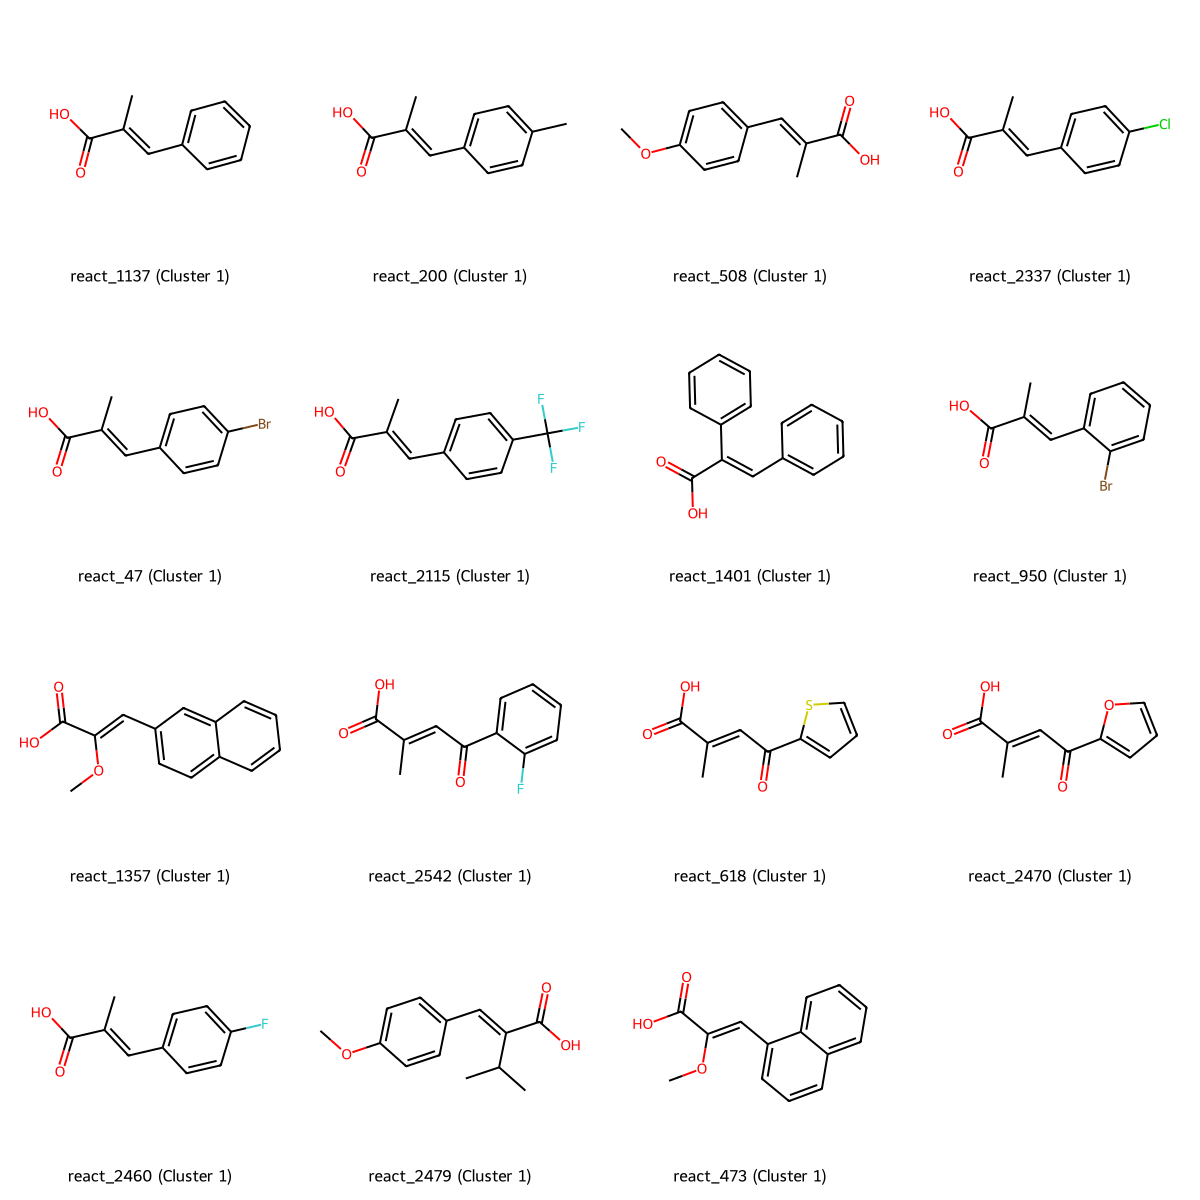

In [ ]:
# Ensure that the Molecule column in reactant_pca_3d_df is populated with valid Molecule IDs from alkene_df
if len(reactant_pca_3d_df) == len(alkene_df):
    # Assign Molecule column from alkene_df to reactant_pca_3d_df
    reactant_pca_3d_df['Molecule'] = alkene_df['Molecule'].values
    print("Assigned Molecule values from alkene_df to reactant_pca_3d_df.")
else:
    print("Mismatch in row counts between reactant_pca_3d_df and alkene_df. Ensure proper alignment.")
    
# Now that Molecule values have been assigned, ensure that Molecule is set as the index if necessary
if 'Molecule' in reactant_pca_3d_df.columns:
    reactant_pca_3d_df.set_index('Molecule', inplace=True)  # Set Molecule as index
    print("Molecule set as index in reactant_pca_3d_df.")
else:
    print("Molecule column is still missing after assignment.")

# Debugging: Print to ensure the Molecule column has been populated
print("First few rows of reactant_pca_3d_df with Molecule as index:")
print(reactant_pca_3d_df.head())

# Now proceed with distance calculations and visualizations after fixing Molecule assignment
cluster_of_interest = 1
cluster_df = alkene_df[alkene_df['Cluster'] == cluster_of_interest]

print("Molecule IDs from cluster_df (Cluster 1):")
print(cluster_df['Molecule'].head())

# Stripping any potential whitespace in both DataFrames
reactant_pca_3d_df.index = reactant_pca_3d_df.index.str.strip()  # Ensure index has no whitespace
cluster_df['Molecule'] = cluster_df['Molecule'].str.strip()

# Continue with distance calculation and visualization
distances_to_centroid = []
for mol_id in cluster_df['Molecule'].unique():
    if mol_id in reactant_pca_3d_df.index:
        # Calculate distance from centroid to each molecule
        dist = euclidean(centroid_of_interest, reactant_pca_3d_df.loc[mol_id])
        distances_to_centroid.append((mol_id, dist))
    else:
        print(f"Molecule ID {mol_id} not found in PCA data")

# Sort distances and get the closest molecules
if distances_to_centroid:
    sorted_distances = sorted(distances_to_centroid, key=lambda x: x[1])
    closest_molecules = [mol_id for mol_id, dist in sorted_distances[:15]]
    print(f"Closest 10-15 molecules to the centroid of Cluster {cluster_of_interest}:")
    print(closest_molecules)

    visualize_group('Cluster 1', closest_molecules, file_path)
else:
    print("No valid molecules found close to centroid for Cluster 1")


Try use variance inflacne factors

      Feature         VIF
0   Q1_charge    5.116675
1   Q2_charge    3.091153
2   Q3_charge    3.696560
3   Q4_charge         NaN
4   C1_charge    6.485091
5   C2_charge    4.125995
6       Q1_B1   38.739446
7       Q1_B5  544.404169
8        Q1_L  570.973351
9       Q2_B1    1.414556
10      Q2_B5    2.567408
11       Q2_L    2.378648
12      Q3_B1    3.989073
13      Q3_B5    3.238782
14       Q3_L    4.216134
15      Q4_B1    1.567995
16      Q4_B5    1.903780
17       Q4_L    2.590101
18    Cluster    1.847344


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_33770/2007939613.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = alkene_df['Cluster'].astype(float)
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_33770/2007939613.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=vif_data, palette="coolwarm")


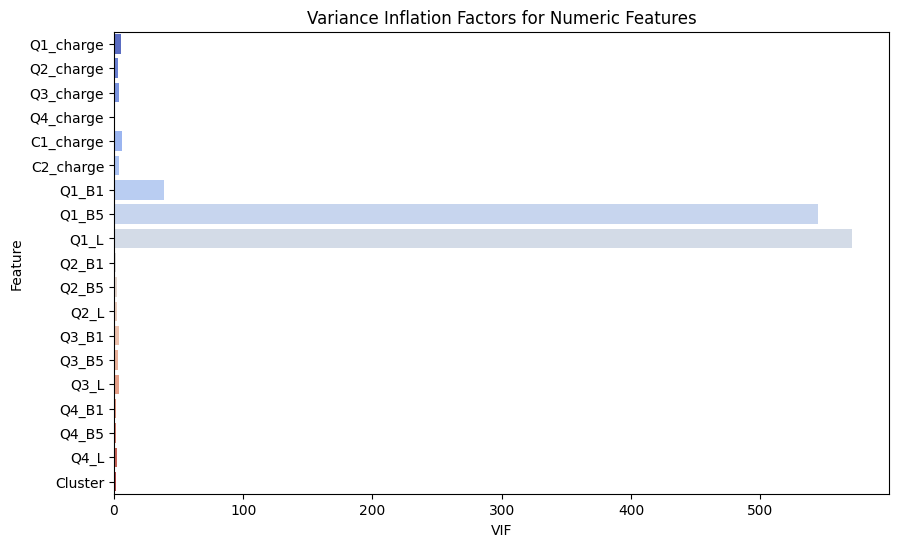

Features with high VIF (greater than 5): ['Q1_charge', 'C1_charge', 'Q1_B1', 'Q1_B5', 'Q1_L']


In [ ]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.preprocessing import StandardScaler
# # Ensure the 'Cluster' column is numeric
# alkene_df['Cluster'] = alkene_df['Cluster'].astype(float)

# # Select only numeric columns from the DataFrame
# numeric_columns = alkene_df.select_dtypes(include=[np.number])

# # Standardize the numeric data to improve VIF calculation accuracy
# scaler = StandardScaler()
# numeric_data_scaled = scaler.fit_transform(numeric_columns)

# # Create a new DataFrame with the scaled data to calculate VIF
# numeric_df_scaled = pd.DataFrame(numeric_data_scaled, columns=numeric_columns.columns)

# # Calculate the VIF for each numeric feature
# vif_data = pd.DataFrame()
# vif_data['Feature'] = numeric_df_scaled.columns
# vif_data['VIF'] = [variance_inflation_factor(numeric_df_scaled.values, i) for i in range(numeric_df_scaled.shape[1])]

# # Print the VIF results
# print(vif_data)

# plt.figure(figsize=(10, 6))
# sns.barplot(x="VIF", y="Feature", data=vif_data, palette="coolwarm")
# plt.title('Variance Inflation Factors for Numeric Features')
# plt.show()

# # Determine features with high VIF values (suggesting multicollinearity)
# vif_threshold = 5  
# high_vif_features = vif_data[vif_data['VIF'] > vif_threshold]['Feature'].tolist()
# print(f"Features with high VIF (greater than {vif_threshold}): {high_vif_features}")

import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure alkene_df exists in your current scope
alkene_df['Cluster'] = alkene_df['Cluster'].astype(float)

# Select only numeric columns from the DataFrame
numeric_columns = alkene_df.select_dtypes(include=[np.number])

# Standardize the numeric data to improve VIF calculation accuracy
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_columns)

# Create a new DataFrame with the scaled data
numeric_df_scaled = pd.DataFrame(numeric_data_scaled, columns=numeric_columns.columns)

# Add a constant column to the scaled DataFrame for VIF calculation
numeric_df_scaled_with_const = add_constant(numeric_df_scaled)

# Calculate the VIF for each feature including the constant
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_df_scaled_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_df_scaled_with_const.values, i) 
                   for i in range(numeric_df_scaled_with_const.shape[1])]

# Print the VIF results
print(vif_data)

# Visualize VIF values using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="VIF", y="Feature", data=vif_data, palette="coolwarm")
plt.title('Variance Inflation Factors for Numeric Features')
plt.xlabel('VIF Value')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

# Determine features with high VIF values (suggesting multicollinearity)
vif_threshold = 5  
high_vif_features = vif_data[vif_data['VIF'] > vif_threshold]['Feature'].tolist()
print(f"Features with high VIF (greater than {vif_threshold}): {high_vif_features}")


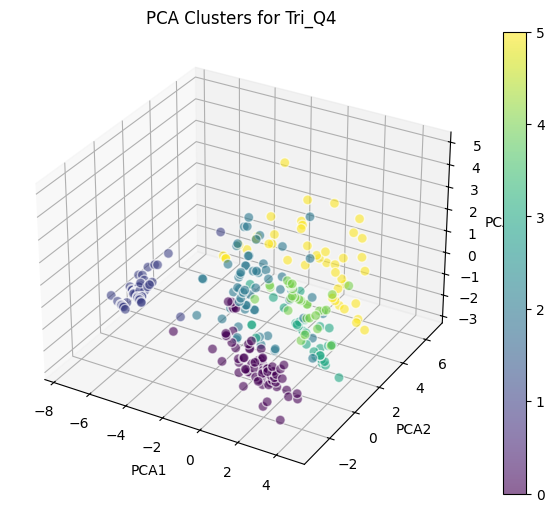

In [14]:
alkene_df_filtered = alkene_df.drop(columns=[ 'Q1_charge', 'C1_charge', 'Q1_B1', 'Q1_B5', 'Q1_L'])

# Select only numeric columns again, now without the two removed features
numeric_columns_filtered = alkene_df_filtered.select_dtypes(include=[np.number])

def perform_pca(df_selected):
    pca = PCA(n_components=3)  # Reduce to 3 components for 3D visualization
    pca_result = pca.fit_transform(df_selected)
    pca_df = pd.DataFrame(pca_result, columns=['Reactant_PCA1', 'Reactant_PCA2', 'Reactant_PCA3'])
    return pca_df

# Perform PCA on the filtered data (after removing the highly correlated features)
reactant_pca_3d_df_filtered = perform_pca(numeric_columns_filtered)

plot_pca_clusters(reactant_pca_3d_df_filtered, alkene_df['Cluster'], "Tri_Q4")

/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


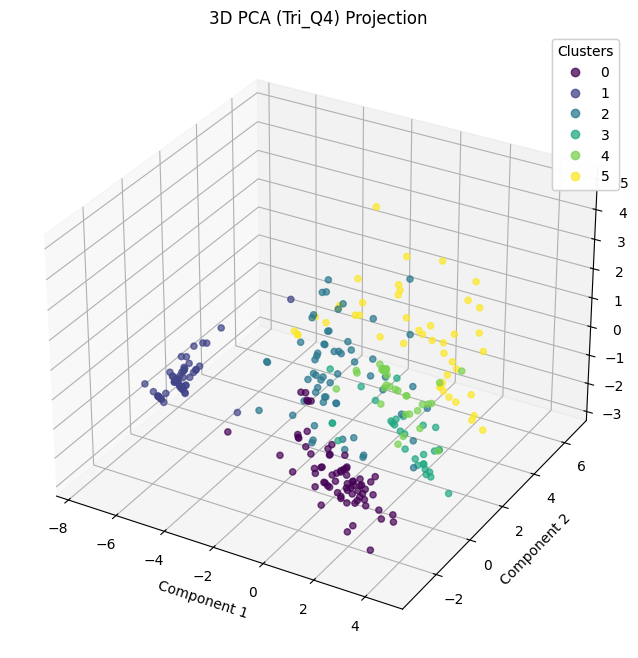

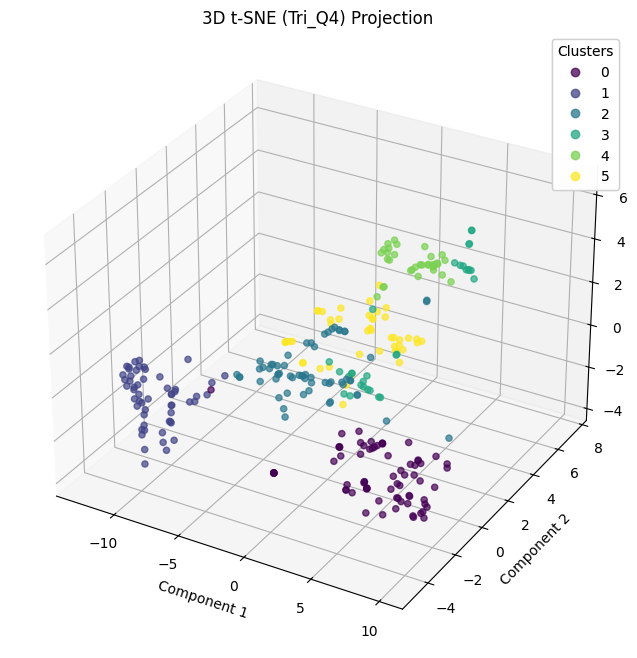

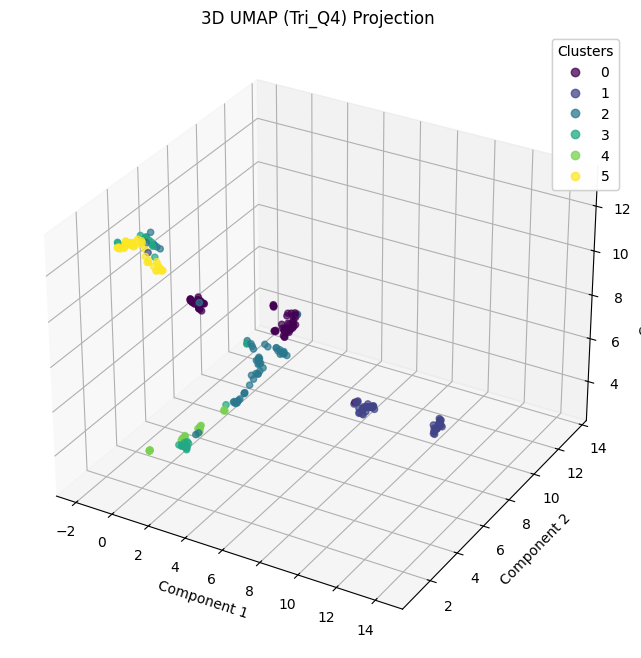

In [15]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming alkene_df is provided, and we are working with the filtered dataset

# Remove specified columns
alkene_df_filtered = alkene_df.drop(columns=['Q1_charge', 'C1_charge', 'Q1_B1', 'Q1_B5', 'Q1_L'])

# Select only numeric columns
numeric_columns_filtered = alkene_df_filtered.select_dtypes(include=[np.number])

# Define function to perform PCA
def perform_pca(df_selected):
    pca = PCA(n_components=3, random_state=42)  # Reduce to 3 components for 3D visualization
    pca_result = pca.fit_transform(df_selected)
    pca_df = pd.DataFrame(pca_result, columns=['Reactant_PCA1', 'Reactant_PCA2', 'Reactant_PCA3'])
    return pca_df

# Perform PCA on the filtered data
reactant_pca_3d_df_filtered = perform_pca(numeric_columns_filtered)

# Define function to perform t-SNE
def perform_tsne(df_selected):
    tsne = TSNE(n_components=3, random_state=42)
    tsne_result = tsne.fit_transform(df_selected)
    tsne_df = pd.DataFrame(tsne_result, columns=['Reactant_TSNE1', 'Reactant_TSNE2', 'Reactant_TSNE3'])
    return tsne_df

# Define function to perform UMAP
def perform_umap(df_selected):
    umap_reducer = umap.UMAP(n_components=3, random_state=42)
    umap_result = umap_reducer.fit_transform(df_selected)
    umap_df = pd.DataFrame(umap_result, columns=['Reactant_UMAP1', 'Reactant_UMAP2', 'Reactant_UMAP3'])
    return umap_df

# Perform t-SNE and UMAP on the filtered data
reactant_tsne_3d_df_filtered = perform_tsne(numeric_columns_filtered)
reactant_umap_3d_df_filtered = perform_umap(numeric_columns_filtered)

# Define a function to plot 3D clusters
def plot_3d_clusters(df, labels, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2], c=labels, cmap='viridis', alpha=0.7)
    legend = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend)
    ax.set_title(f'3D {title} Projection')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

# Plot the results for PCA, t-SNE, and UMAP
plot_3d_clusters(reactant_pca_3d_df_filtered, alkene_df['Cluster'], "PCA (Tri_Q4)")
plot_3d_clusters(reactant_tsne_3d_df_filtered, alkene_df['Cluster'], "t-SNE (Tri_Q4)")
plot_3d_clusters(reactant_umap_3d_df_filtered, alkene_df['Cluster'], "UMAP (Tri_Q4)")


1. What criteria should be used to decide between PCA, t-SNE, and UMAP for visualizing and interpreting cluster separation？ 

2. How do you usually validate the results of dimensionality reduction in your research?

3. Given that UMAP sometimes compresses space too much, how can we balance the need for compact clusters with maintaining meaningful global structure in the visualization?



UMAP seems to capture the cluster structure the best with distinct separations and compact clusters.


Calculate VIF for each feature.
Remove features with high VIF values.
Continue with the UMAP and clustering workflow.

Dropped feature: Q1_B5 with VIF: 129.06097473180085
Dropped feature: C2_charge with VIF: 30.093047284153815
Dropped feature: Q3_L with VIF: 22.1643104205237
Dropped feature: Q2_B5 with VIF: 16.704380680430354
Dropped feature: Q4_B5 with VIF: 15.208039924221325


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_79822/2464780851.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(reactant_tsne_3d_df)


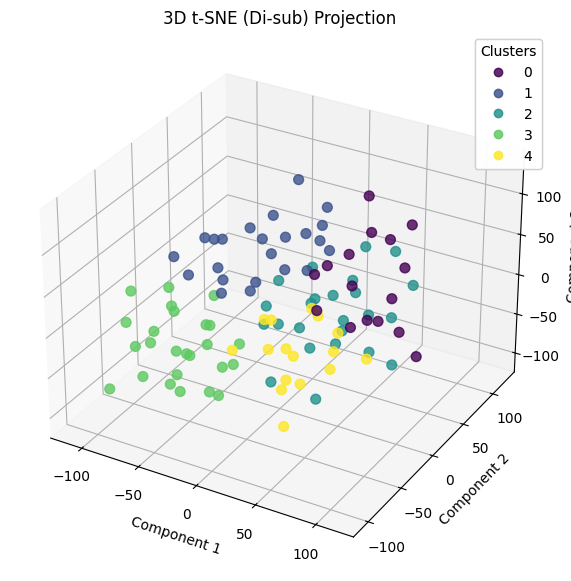

Dropped feature: Q1_L with VIF: 40.7874107028106
Dropped feature: Q2_charge with VIF: 18.778855221508476
Dropped feature: Q3_L with VIF: 15.58609245390538
Dropped feature: Q1_B1 with VIF: 13.457138330844266
Dropped feature: C2_charge with VIF: 10.324497025001588


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_79822/2464780851.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(reactant_tsne_3d_df)


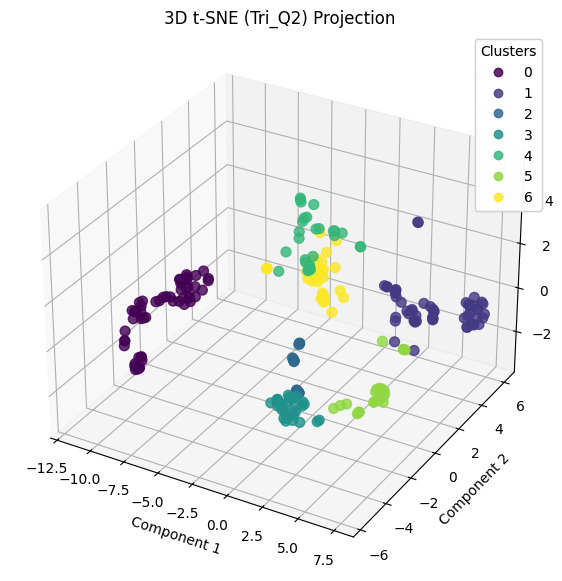

Dropped feature: Q4_B1 with VIF: 42.35010870142844
Dropped feature: Q3_B5 with VIF: 14.994790424756255
Dropped feature: Q1_L with VIF: 14.047428802751824
Dropped feature: Q2_L with VIF: 11.144983982587455


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_79822/2464780851.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(reactant_tsne_3d_df)


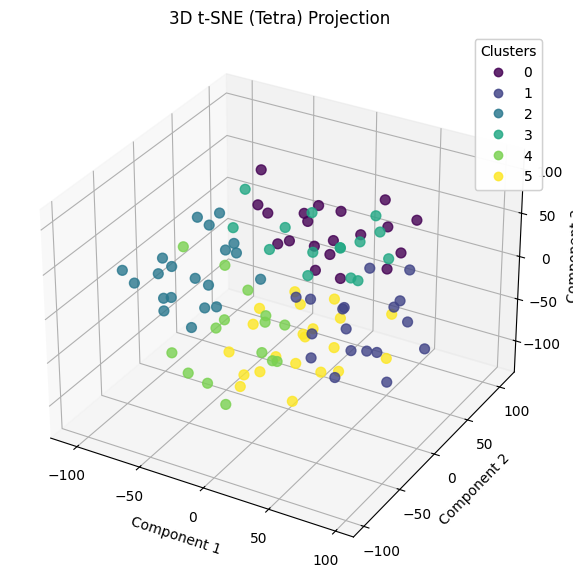

Dropped feature: Q1_B1 with VIF: 36.16340231485385
Dropped feature: Q2_charge with VIF: 23.815016752486645
Dropped feature: Q2_B5 with VIF: 12.832510656064546
Dropped feature: Q3_charge with VIF: 10.104076124940885


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_79822/2464780851.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(reactant_tsne_3d_df)


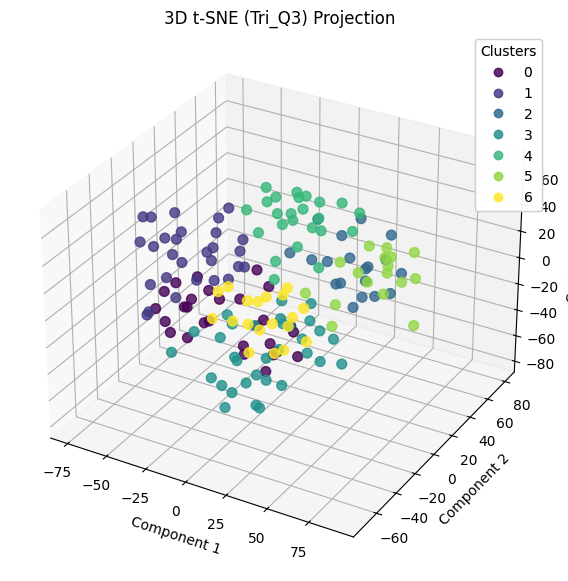

Dropped feature: Q1_L with VIF: 695.1136469503489
Dropped feature: Q1_B1 with VIF: 45.4228912094248
Dropped feature: C1_charge with VIF: 37.95885141304961
Dropped feature: Q3_L with VIF: 13.425739595273848
Dropped feature: Q3_B1 with VIF: 13.329902498707542


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_79822/2464780851.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(reactant_tsne_3d_df)


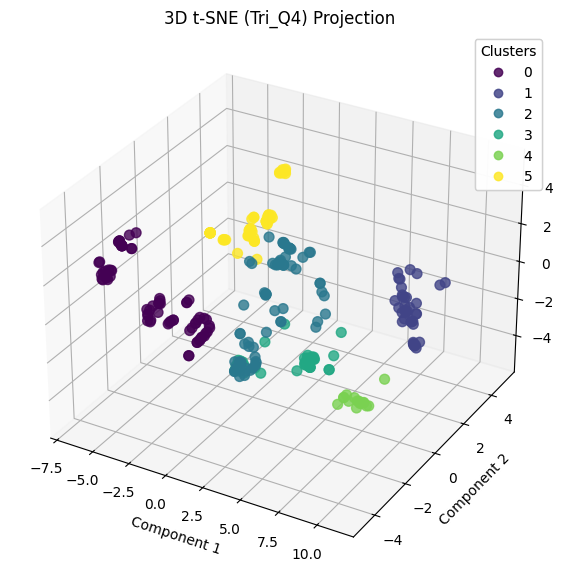

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor
from rdkit import Chem
from rdkit.Chem import Draw
import os
import umap
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset with Reactant SMILES and IDs
file_path_smiles = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/alkene/fixed_react_map_aho_dataset.xlsx'
df_smiles = pd.read_excel(file_path_smiles)

# Load the dataset for UMAP and clustering
file_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/machine_learning/combined_molecule_data_with_alkene_type.xlsx'
df = pd.read_excel(file_path)

# Define the alkene types and their respective cluster numbers
alkene_cluster_map = {
    'Di-sub': 5,
    'Tri_Q2': 7,
    'Tetra': 6,
    'Tri_Q3': 7,
    'Tri_Q4': 6
}

# Directory to save the visualizations
output_folder = "cluster_molecule_visualizations_tsne"
os.makedirs(output_folder, exist_ok=True)

# Function to calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Function to combine and save molecules for a specific group
def save_combined_molecule_image(reactant_ids, group_name, file_path):
    # Filter the DataFrame to get rows with the specified Reactant IDs
    filtered_df = df_smiles[df_smiles['Reactant ID'].isin(reactant_ids)]

    # Extract unique SMILES strings corresponding to the reactant IDs
    unique_smiles_df = filtered_df[['Reactant ID', 'Reactant SMILES']].drop_duplicates(subset='Reactant SMILES')

    # Convert SMILES strings to RDKit Mol objects, filtering out any invalid ones
    mols = []
    valid_legends = []
    for index, row in unique_smiles_df.iterrows():
        mol = Chem.MolFromSmiles(row['Reactant SMILES'])
        if mol is not None:
            mols.append(mol)
            # Create a label that includes both the Reactant ID and the corresponding _Alkene_Type
            legend = f"{row['Reactant ID']} ({group_name})"
            valid_legends.append(legend)

    # Save a combined image of all molecules in the cluster
    if mols:  # Ensure there are molecules to display
        img = Draw.MolsToImage(mols, subImgSize=(300, 300), legends=valid_legends)  # Directly get PIL image using MolsToImage
        img.save(file_path)  # Save the image directly
    else:
        print(f"No valid molecules to save for group: {group_name}")

# Iterate over each alkene type and find the molecules closest to the centroids
for alkene_type, n_clusters in alkene_cluster_map.items():
    # Step 1: Filter the DataFrame for the current alkene type
    alkene_df = df[df['_Alkene_Type'] == alkene_type]

    # Step 2: Select only numeric columns
    df_numeric = alkene_df.select_dtypes(include=[float, int])
    df_numeric = df_numeric.dropna()

    # Step 3: Apply MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

    # Step 4: Apply VarianceThreshold to remove low-variance features
    selector = VarianceThreshold(threshold=0)
    df_selected = pd.DataFrame(selector.fit_transform(df_scaled), columns=df_scaled.columns[selector.get_support()])

    # Step 5: Calculate VIF and iteratively remove high VIF features
    vif_data = calculate_vif(df_selected)
    features_dropped = 0
    max_features_to_drop = 5

    while True:
        # Find the feature with the maximum VIF
        max_vif = vif_data['VIF'].max()
        max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']

        # If max VIF > 10 and we haven't reached the limit, drop the feature
        if max_vif > 10 and features_dropped < max_features_to_drop:
            df_selected = df_selected.drop(columns=[max_vif_feature])
            features_dropped += 1
            print(f"Dropped feature: {max_vif_feature} with VIF: {max_vif}")
            # Recalculate VIF
            vif_data = calculate_vif(df_selected)
        else:
            break
    
    # Define reactant features after feature selection
    reactant_features = [col for col in df_selected.columns if 'Q2' not in col and 'Q3' not in col and ('Q' in col or 'C' in col)]

    # Check the shape of the filtered data
    if df_selected.shape[0] > 3 and df_selected.shape[1] > 3:
        # Step 6: Apply t-SNE to reduce dimensions to 3 components
        tsne_reactants_3d = TSNE(n_components=3, random_state=42)
        reactant_tsne_3d = tsne_reactants_3d.fit_transform(df_selected[reactant_features])

        # Convert the t-SNE-transformed features back to a DataFrame
        reactant_tsne_3d_df = pd.DataFrame(reactant_tsne_3d, columns=[f'Reactant_TSNE{i+1}' for i in range(reactant_tsne_3d.shape[1])])

        # Step 7: Apply KMeans clustering based on the elbow point for this alkene type
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        alkene_df['Cluster'] = kmeans.fit_predict(reactant_tsne_3d_df)

        # Compute the centroids of each cluster
        centroids = kmeans.cluster_centers_

        # Find the molecules closest to each centroid
        distances = cdist(centroids, reactant_tsne_3d_df, 'euclidean')
        closest_indices = distances.argsort(axis=1)[:, :10]  # Get 10 closest indices per cluster

        # Get the Reactant IDs closest to the centroids
        for cluster_idx, indices in enumerate(closest_indices):
            closest_molecules = alkene_df.iloc[indices]['Molecule'].values
            
            # Step 8: Save the combined image for the cluster
            combined_image_path = os.path.join(output_folder, f'{alkene_type}_Cluster_{cluster_idx + 1}_combined.png')
            save_combined_molecule_image(closest_molecules, f'{alkene_type}_Cluster_{cluster_idx + 1}', combined_image_path)

        # Plotting t-SNE for visualization
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reactant_tsne_3d_df['Reactant_TSNE1'], reactant_tsne_3d_df['Reactant_TSNE2'], reactant_tsne_3d_df['Reactant_TSNE3'], 
                             c=alkene_df['Cluster'], cmap='viridis', s=50, alpha=0.8)
        ax.set_title(f'3D t-SNE ({alkene_type}) Projection')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
        ax.add_artist(legend1)
        plt.show()
    else:
        print(f"Insufficient samples or features to perform t-SNE for {alkene_type}. Consider adjusting thresholds or filtering criteria.")


Columns in df_smiles: Index(['Rxn ID', 'Reactant ID', 'Reactant SMILES', 'Product ID',
       'Product SMILES', 'Solvent ID', 'Solvent SMILES', 'Additive SMILES',
       'Metal', 'Ligand ID', 'Ligand SMILES', 'Catalyst ID',
       'Catalyst SMILES(RDKit)', 'Pressure/atm', 'Temperature/C', 'S/C',
       'Conv.', 'Yield', 'ddG', 'ee', 'Scaffold type', 'Multi-scaffold type',
       'Dihedral Tag', 'Match Pattern', 'Match Pattern Back', 'Match Index',
       'Olefin Type', 'DOI'],
      dtype='object')
Columns in df: Index(['Molecule', 'Q1_charge', 'Q2_charge', 'Q3_charge', 'Q4_charge',
       'C1_charge', 'C2_charge', 'Q1_B1', 'Q1_B5', 'Q1_L', 'Q2_B1', 'Q2_B5',
       'Q2_L', 'Q3_B1', 'Q3_B5', 'Q3_L', 'Q4_B1', 'Q4_B5', 'Q4_L',
       '_Alkene_Type'],
      dtype='object')
Processing alkene type: Di-sub with 5 clusters
Visualizing group: Di-sub_Cluster_0


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_79822/2626852567.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(df_scaled)


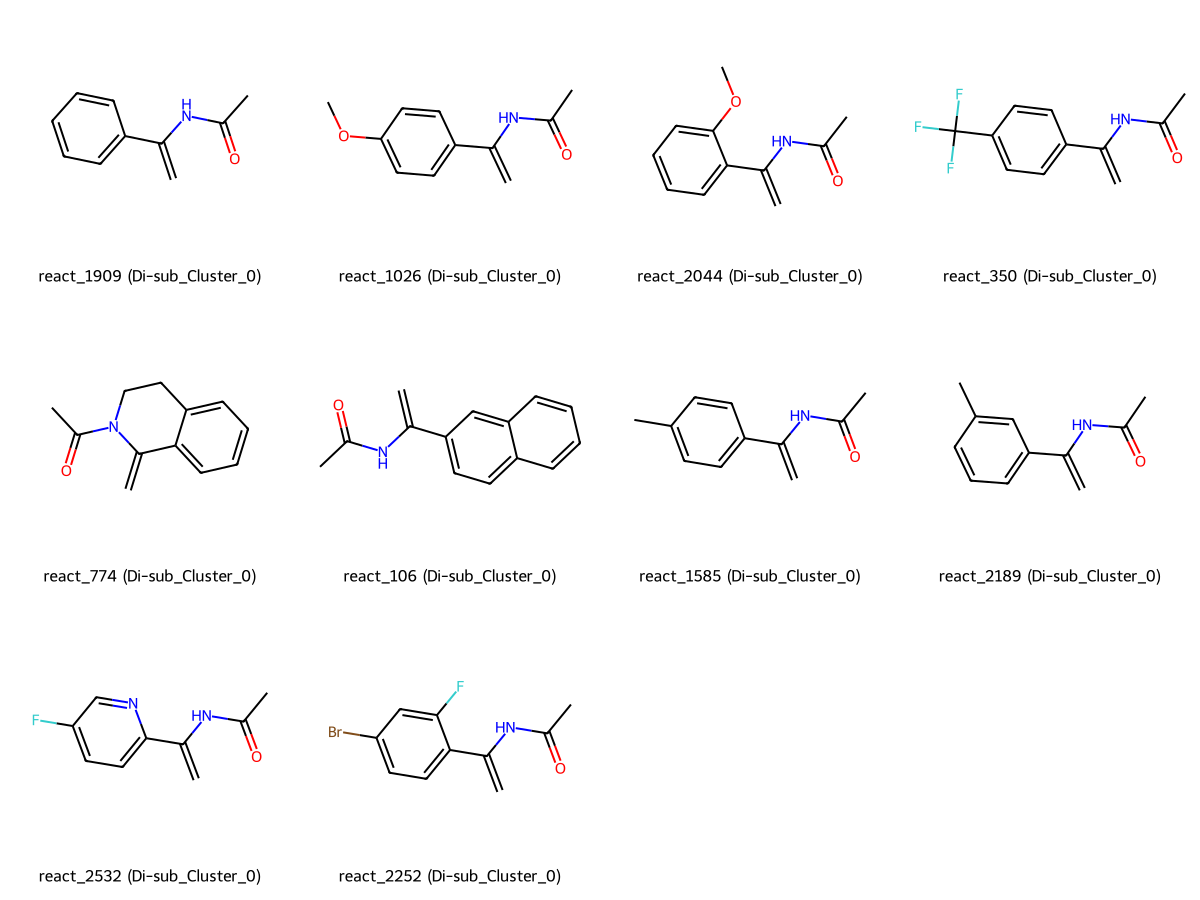

Visualizing group: Di-sub_Cluster_1


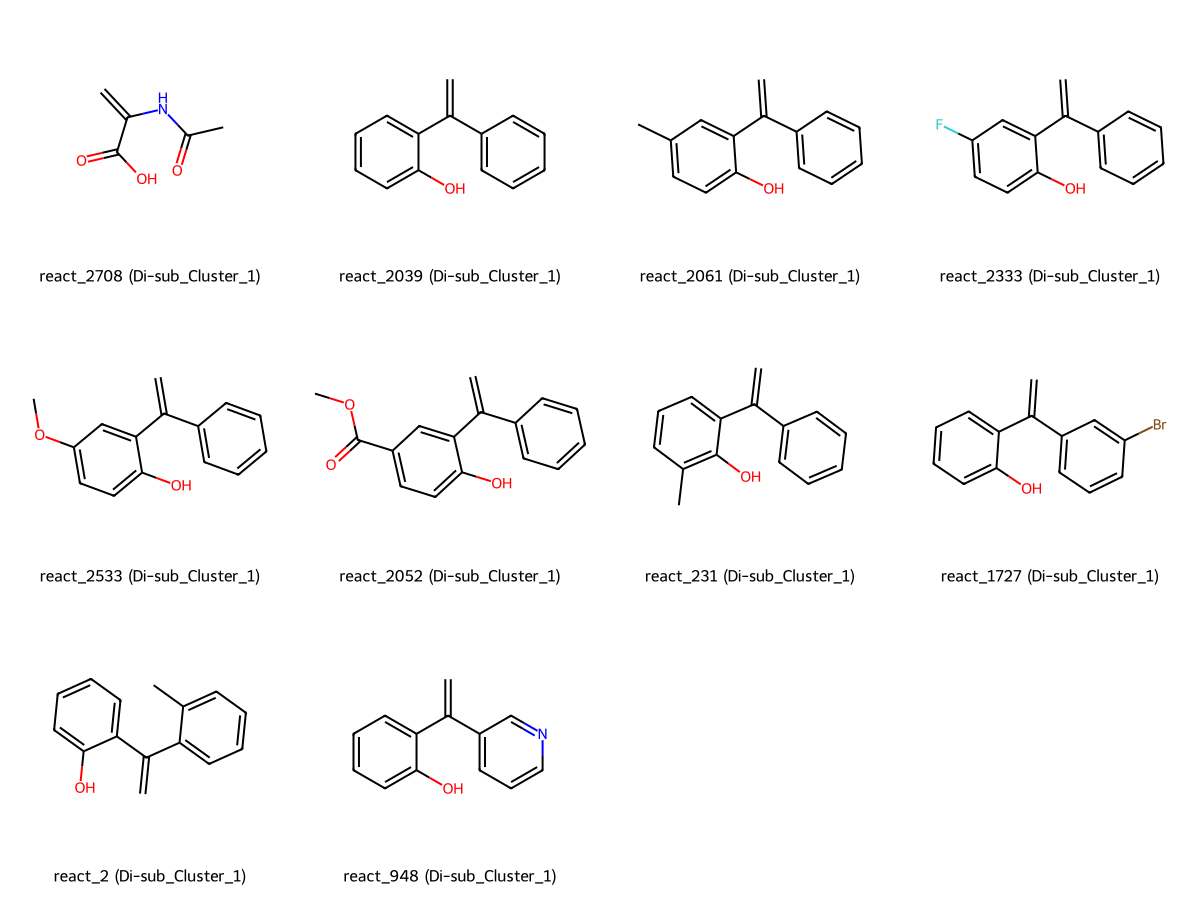

Visualizing group: Di-sub_Cluster_2


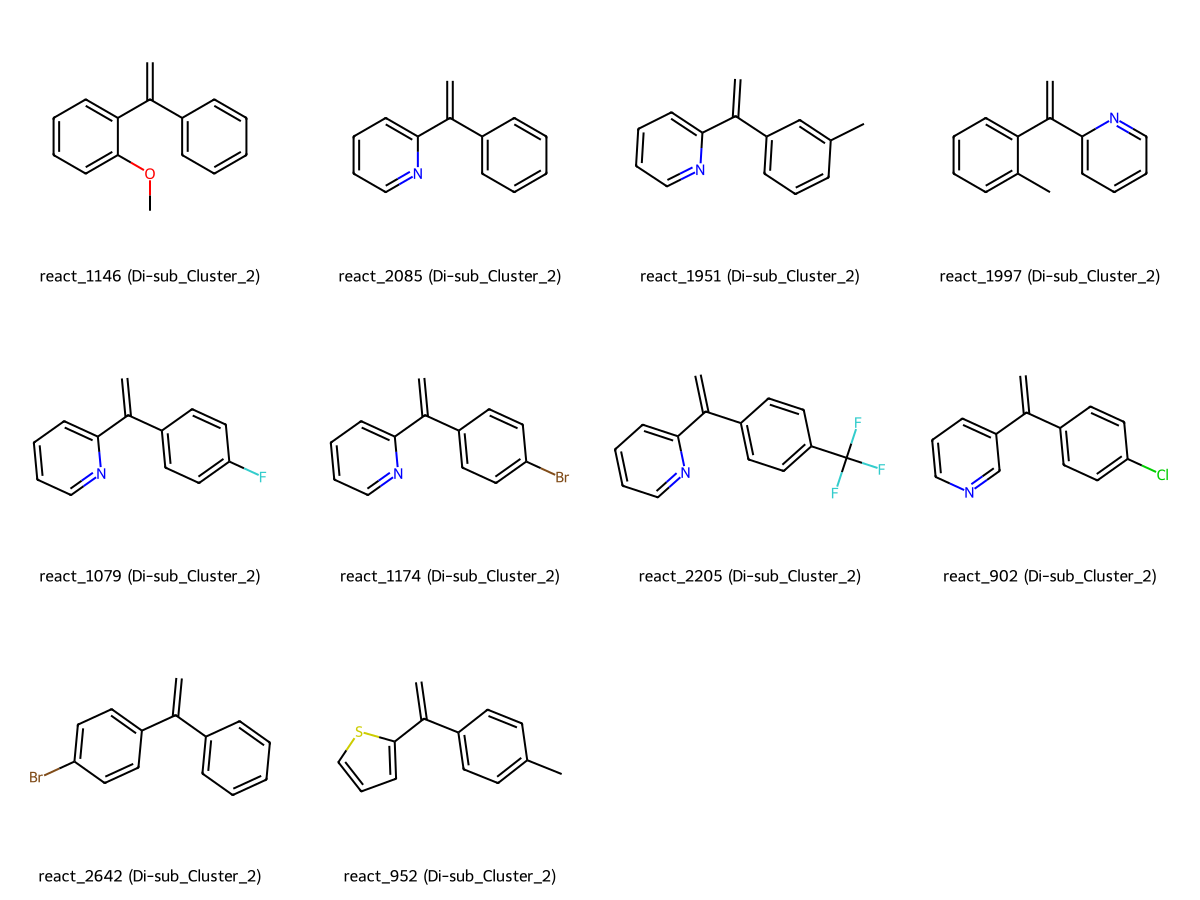

Visualizing group: Di-sub_Cluster_3


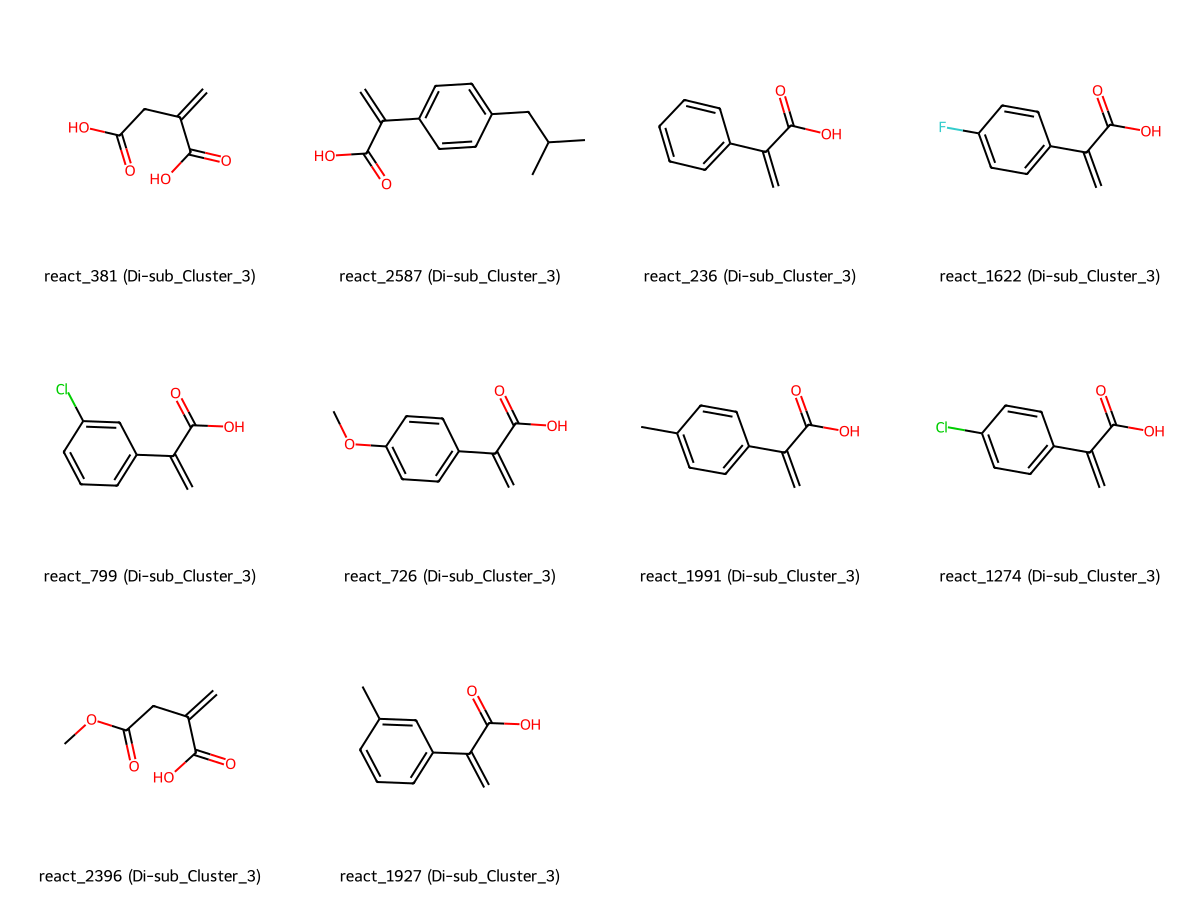

Visualizing group: Di-sub_Cluster_4


Processing alkene type: Tri_Q2 with 7 clusters
Visualizing group: Tri_Q2_Cluster_0


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_79822/2626852567.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(df_scaled)


Visualizing group: Tri_Q2_Cluster_1


Visualizing group: Tri_Q2_Cluster_2


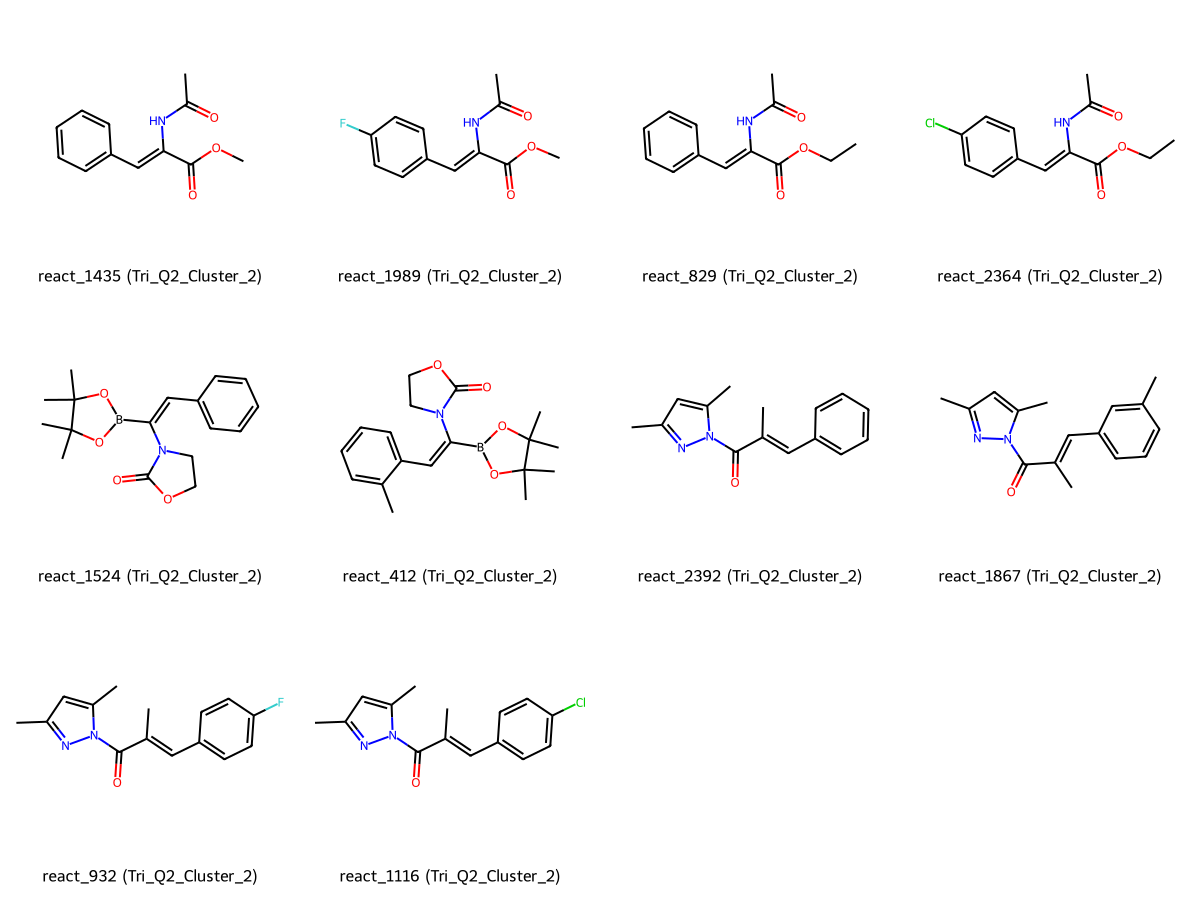

Visualizing group: Tri_Q2_Cluster_3


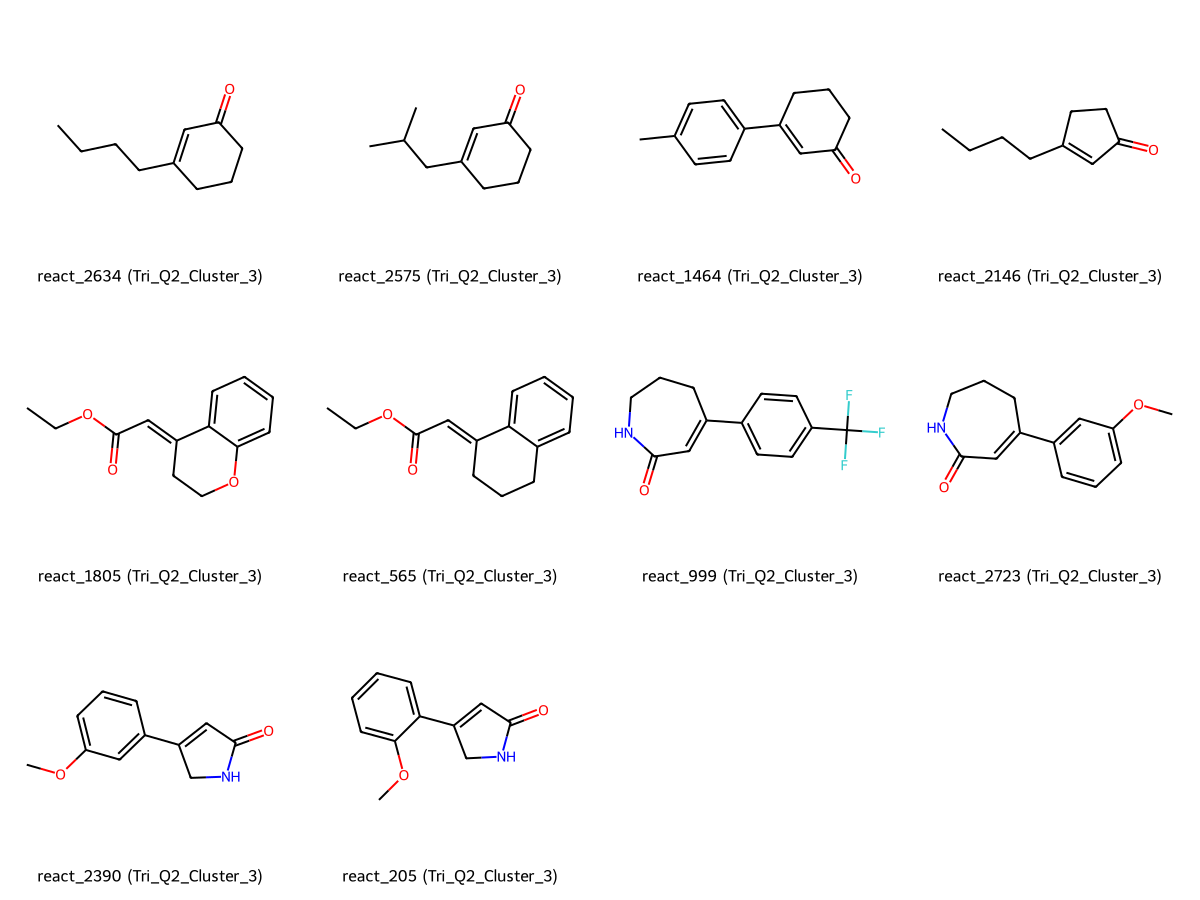

Visualizing group: Tri_Q2_Cluster_4


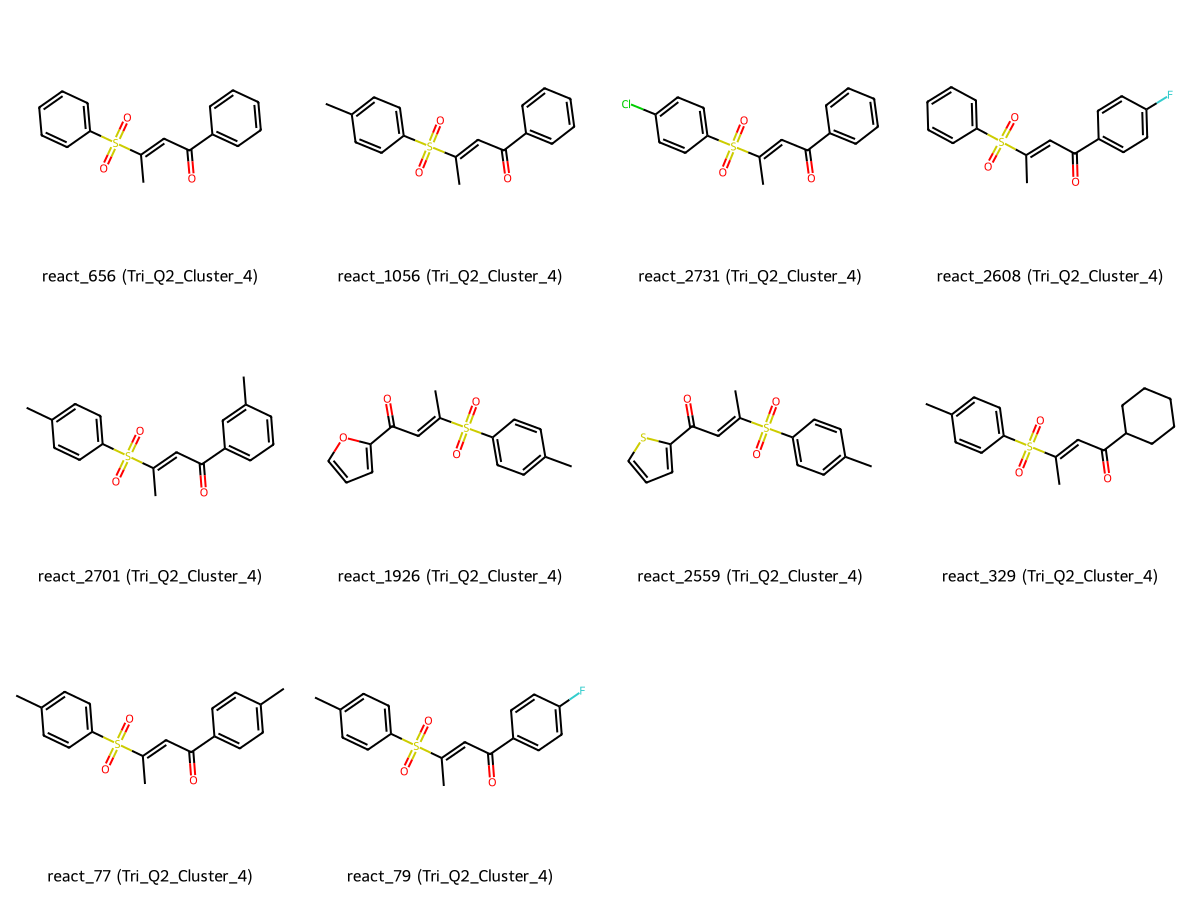

Visualizing group: Tri_Q2_Cluster_5


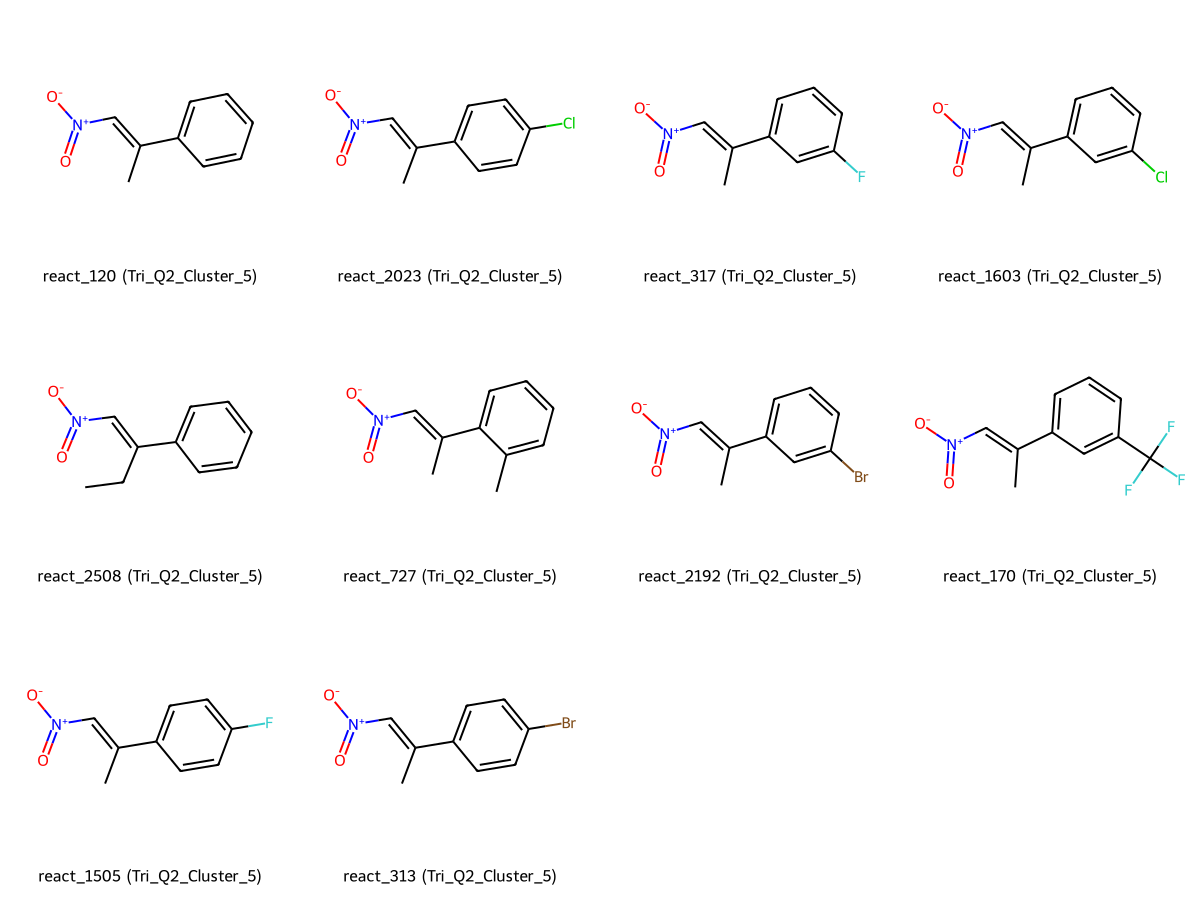

Visualizing group: Tri_Q2_Cluster_6


Processing alkene type: Tetra with 6 clusters
Visualizing group: Tetra_Cluster_0


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_79822/2626852567.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(df_scaled)


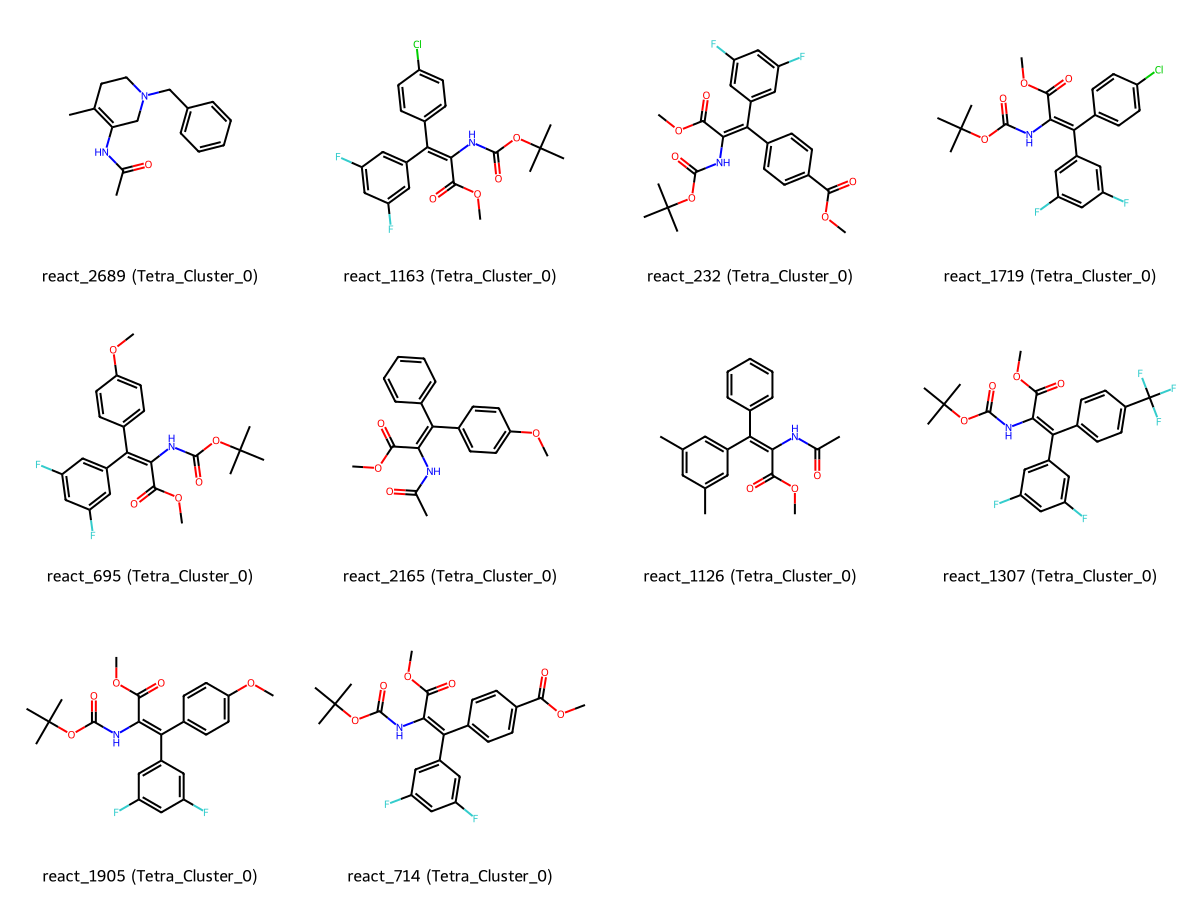

Visualizing group: Tetra_Cluster_1


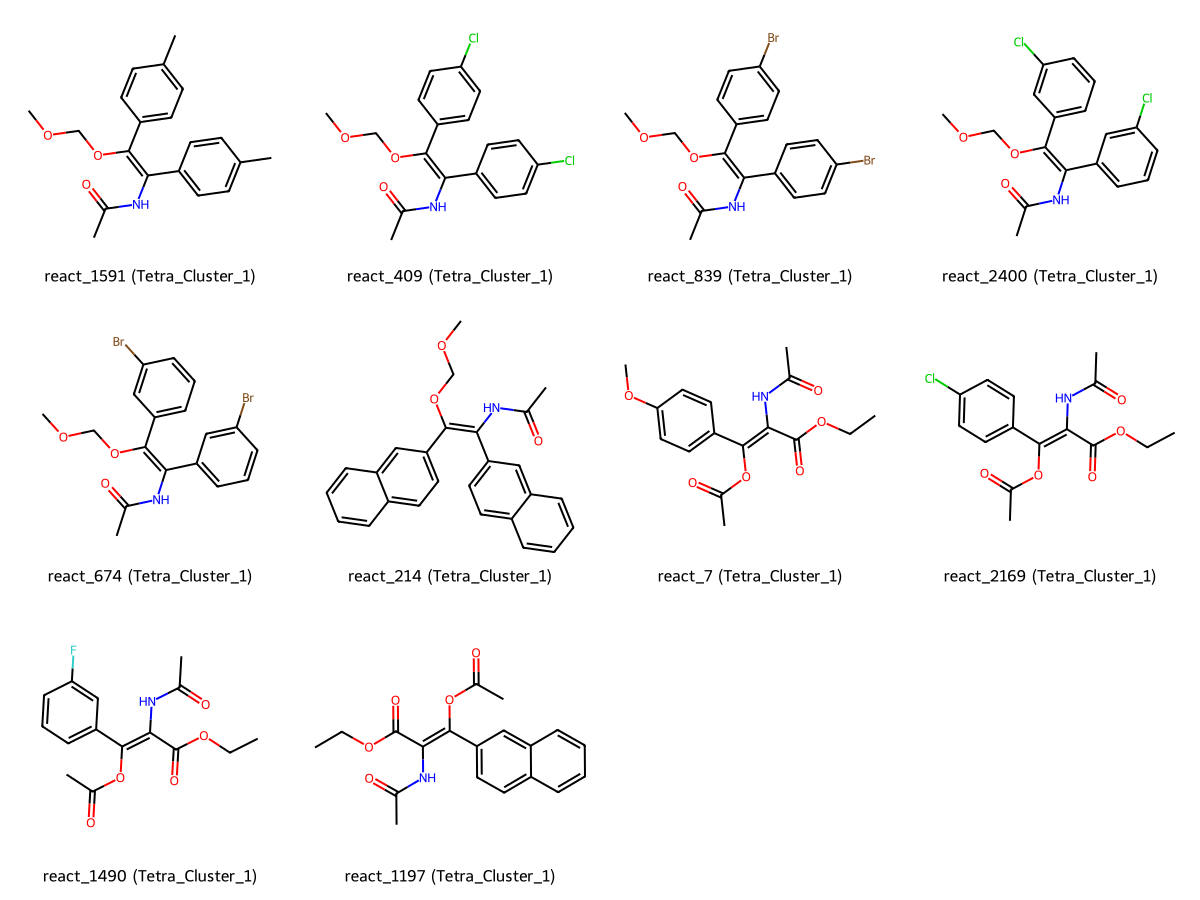

Visualizing group: Tetra_Cluster_2


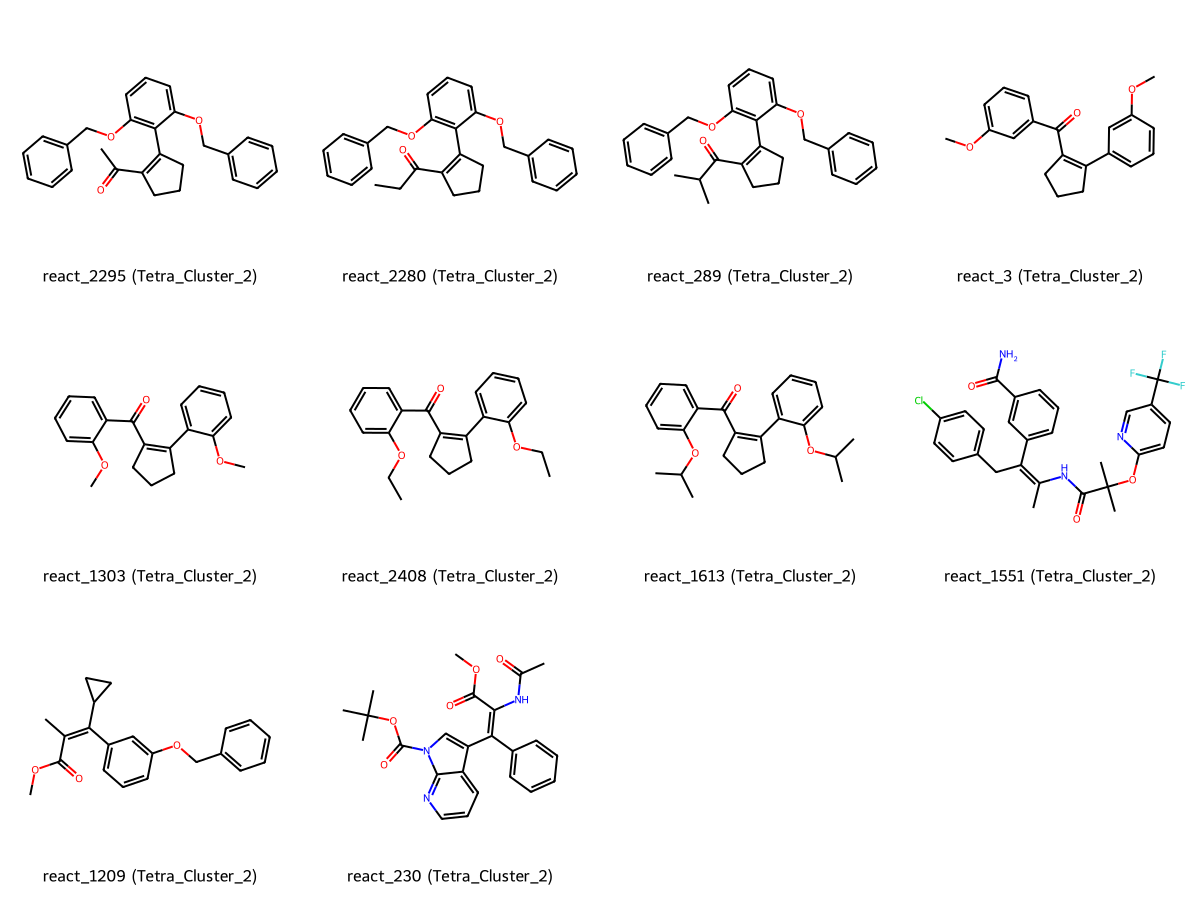

Visualizing group: Tetra_Cluster_3


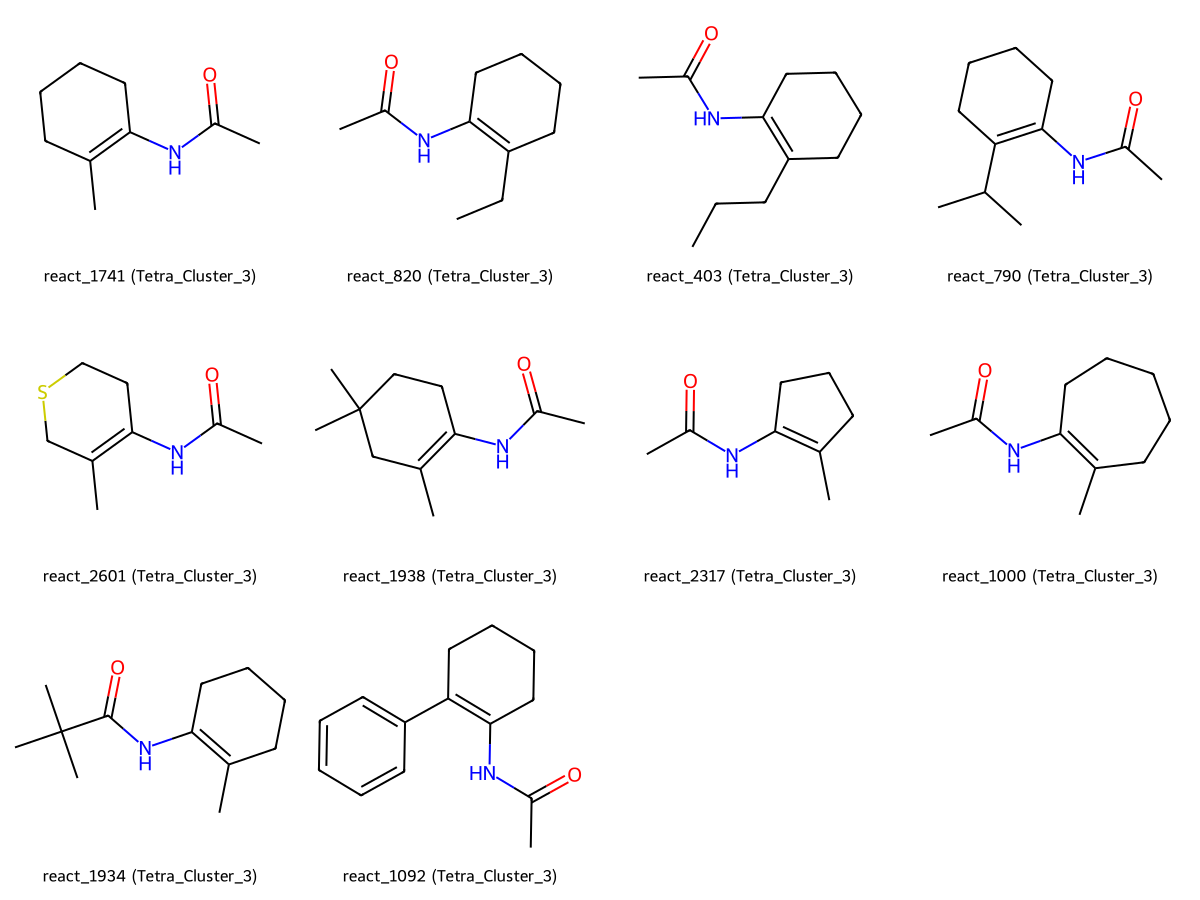

Visualizing group: Tetra_Cluster_4


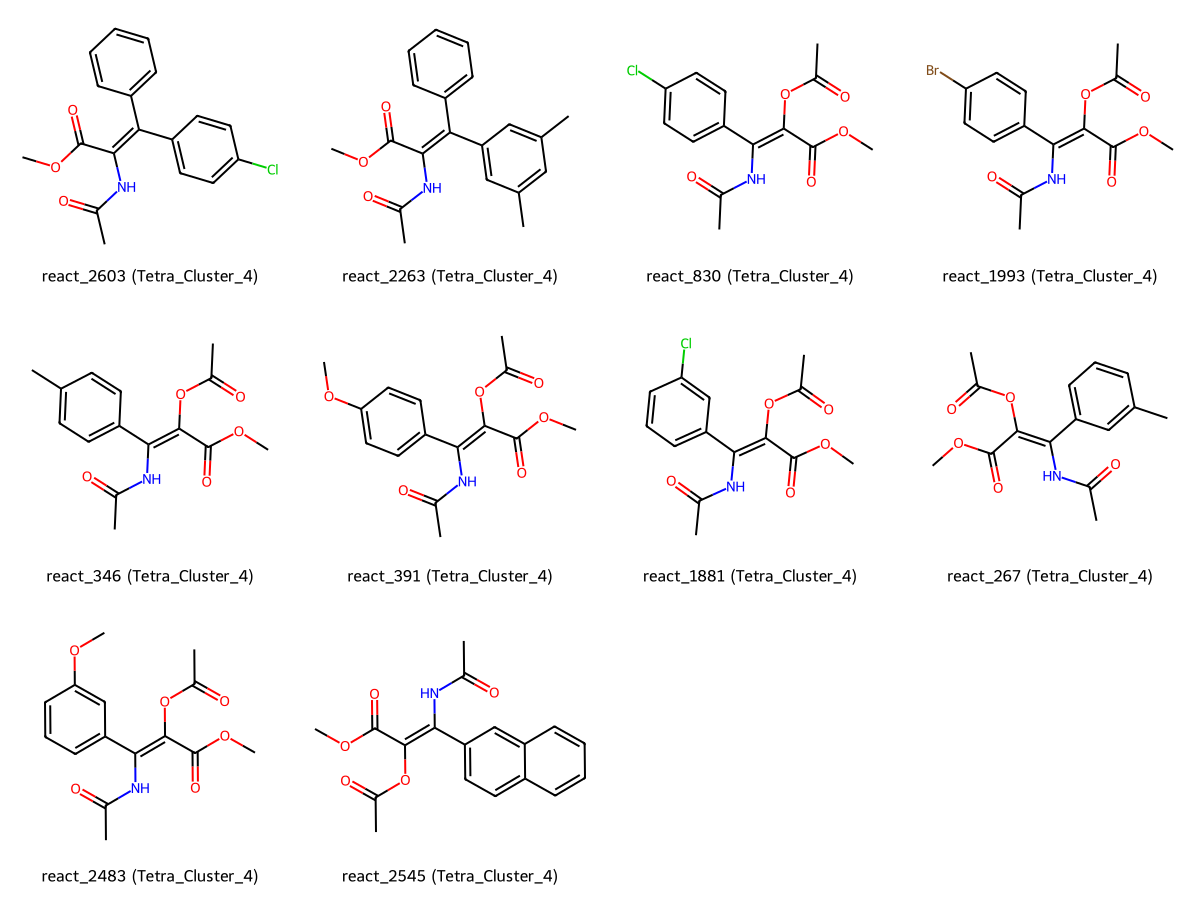

Visualizing group: Tetra_Cluster_5


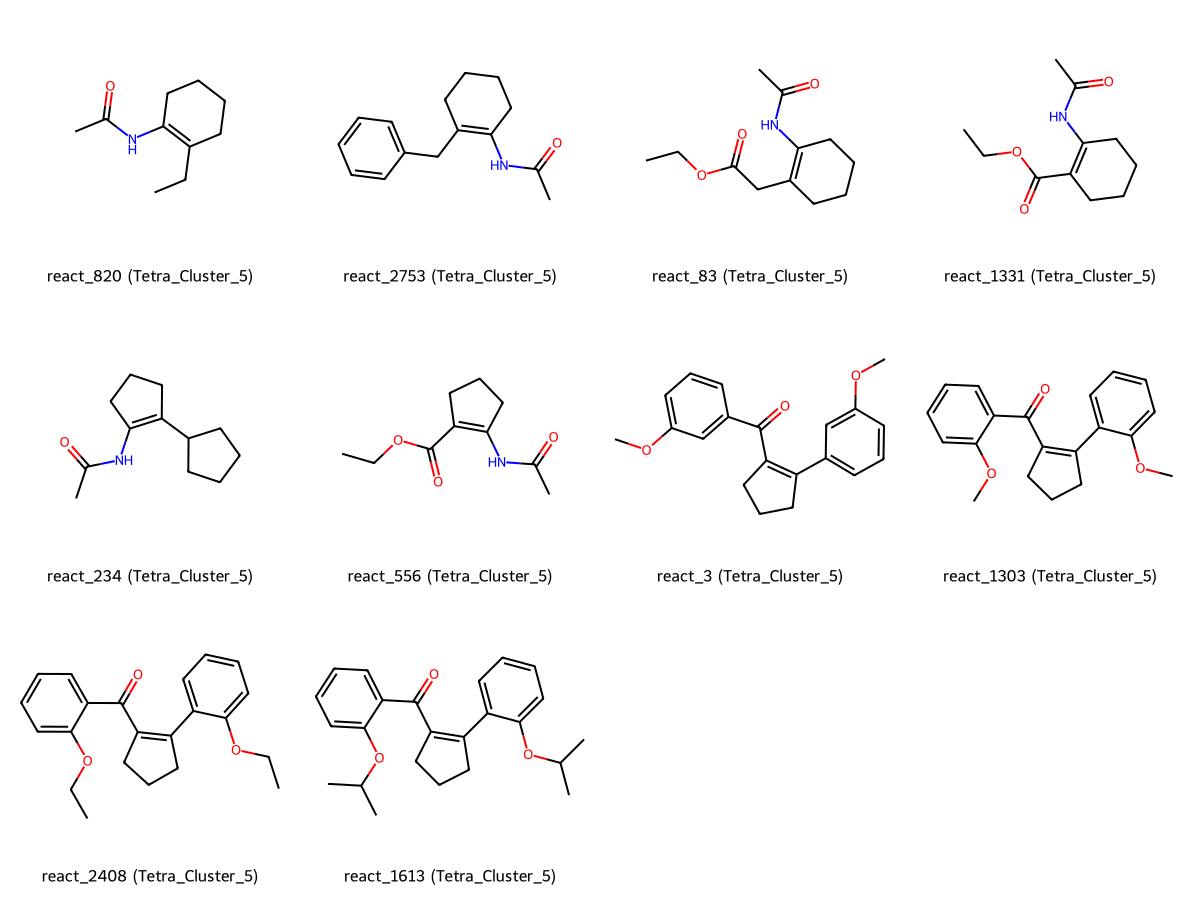

Processing alkene type: Tri_Q3 with 7 clusters
Visualizing group: Tri_Q3_Cluster_0


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_79822/2626852567.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(df_scaled)


Visualizing group: Tri_Q3_Cluster_1


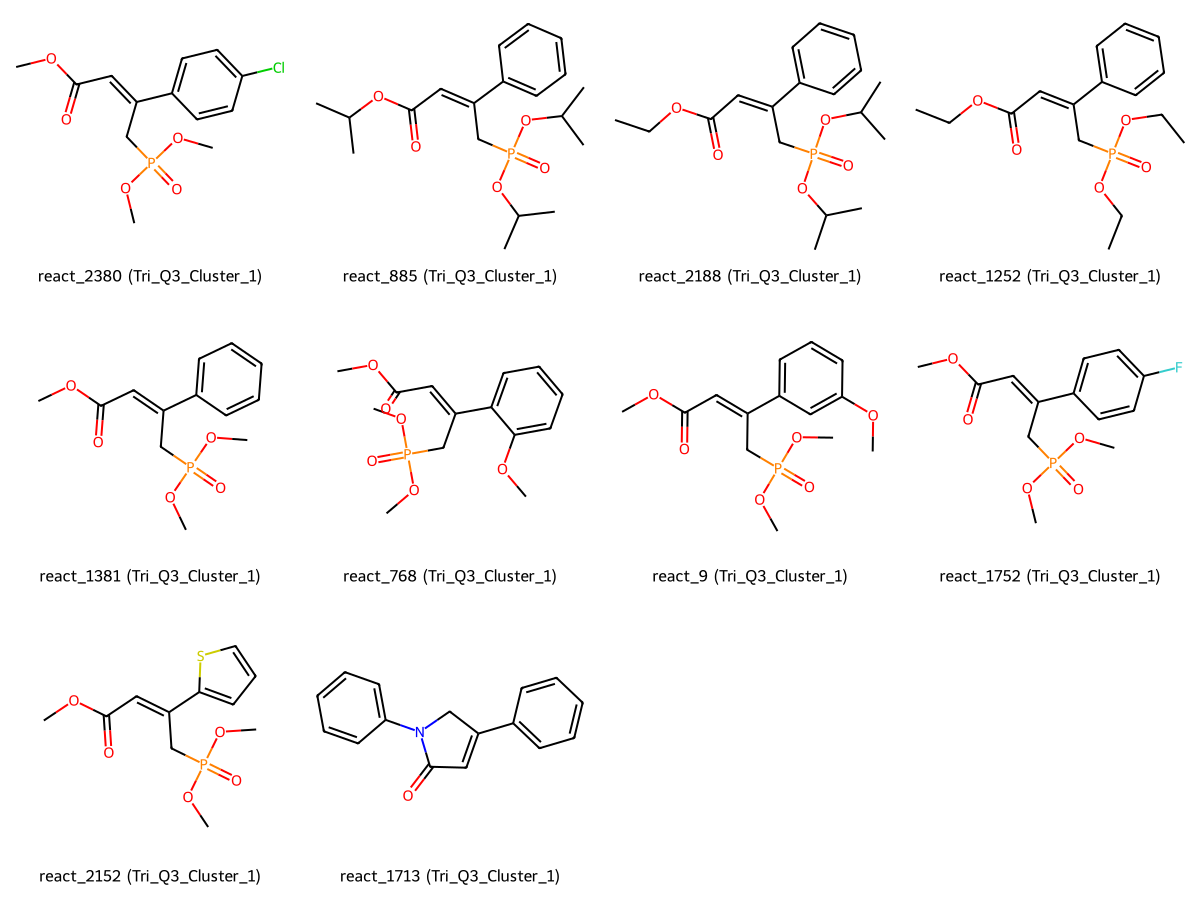

Visualizing group: Tri_Q3_Cluster_2


Visualizing group: Tri_Q3_Cluster_3


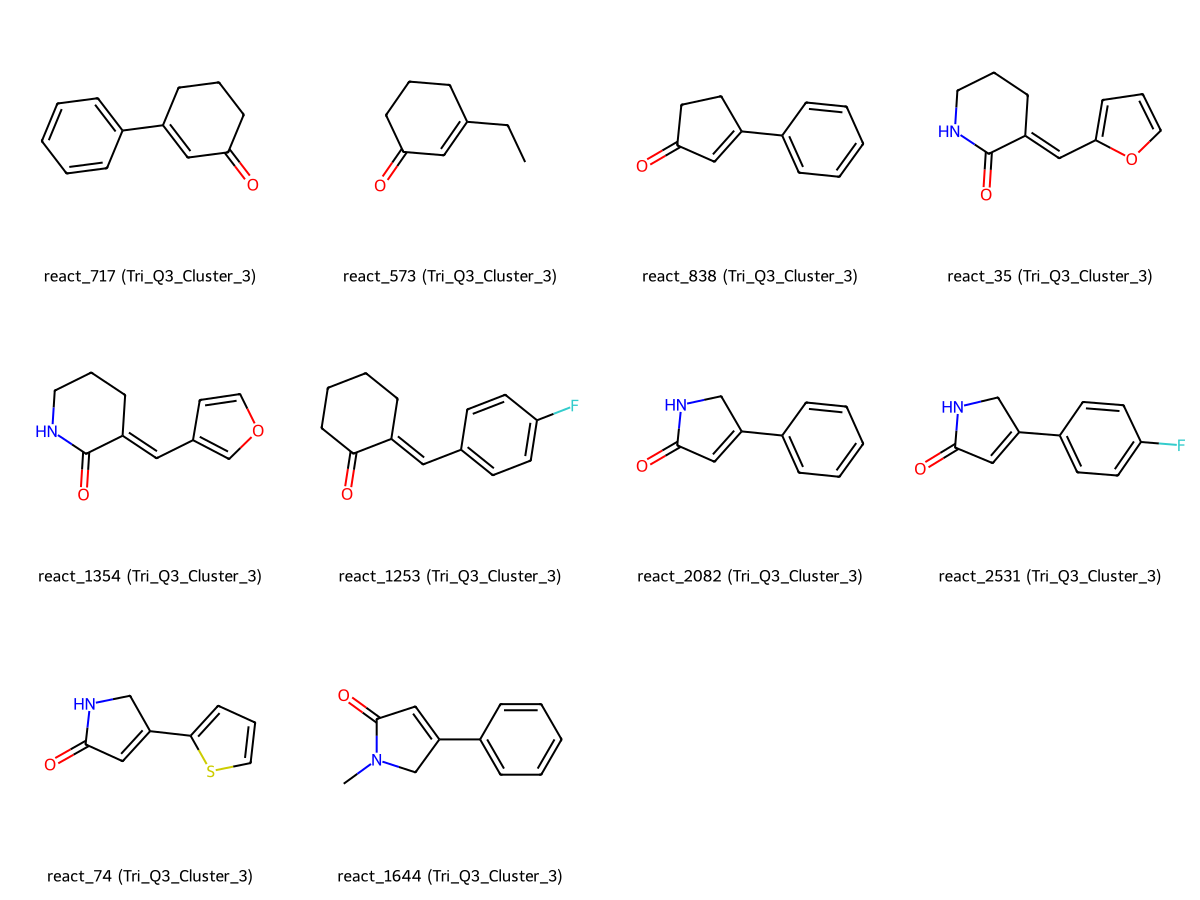

Visualizing group: Tri_Q3_Cluster_4


Visualizing group: Tri_Q3_Cluster_5


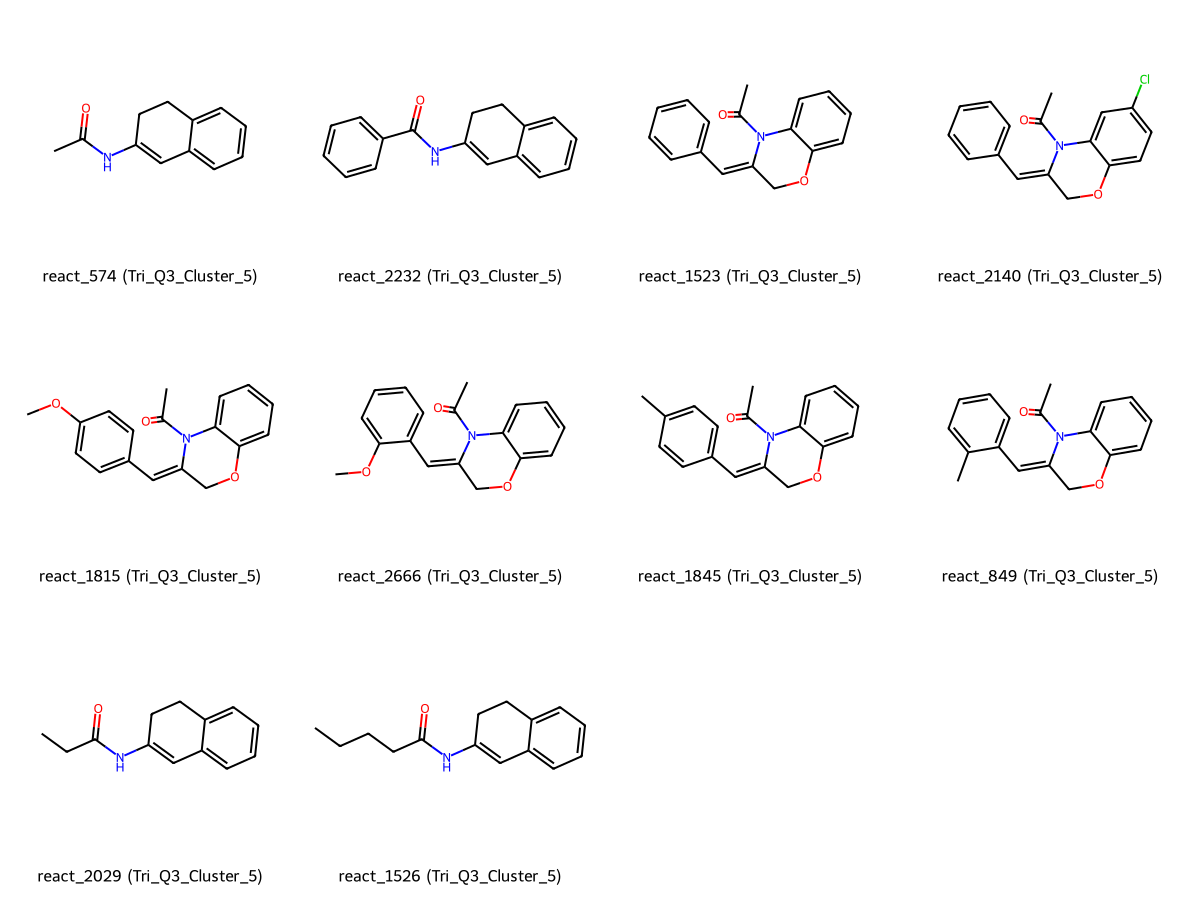

Visualizing group: Tri_Q3_Cluster_6


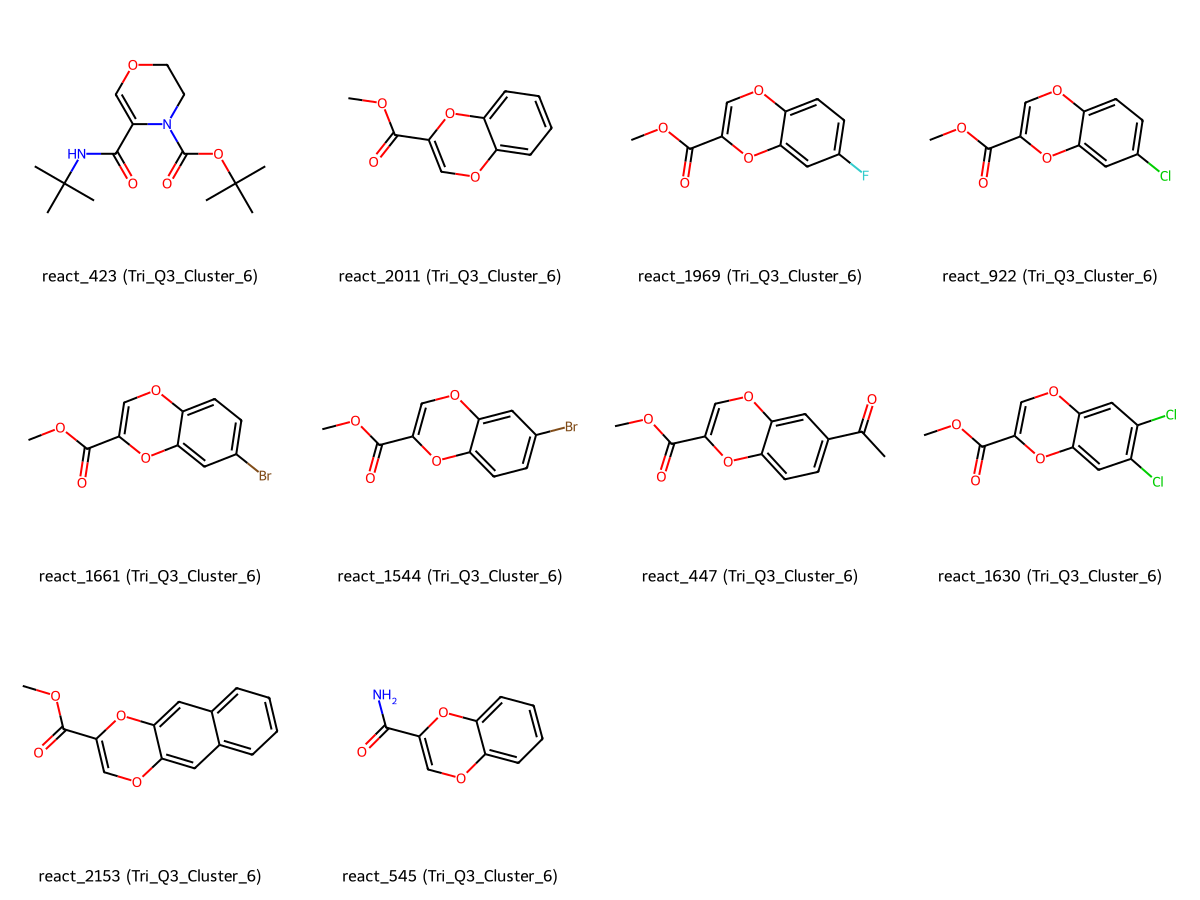

Processing alkene type: Tri_Q4 with 6 clusters
Visualizing group: Tri_Q4_Cluster_0


/var/folders/jl/0pd2mjc15rgdbry4yptmnk4h0000gn/T/ipykernel_79822/2626852567.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alkene_df['Cluster'] = kmeans.fit_predict(df_scaled)


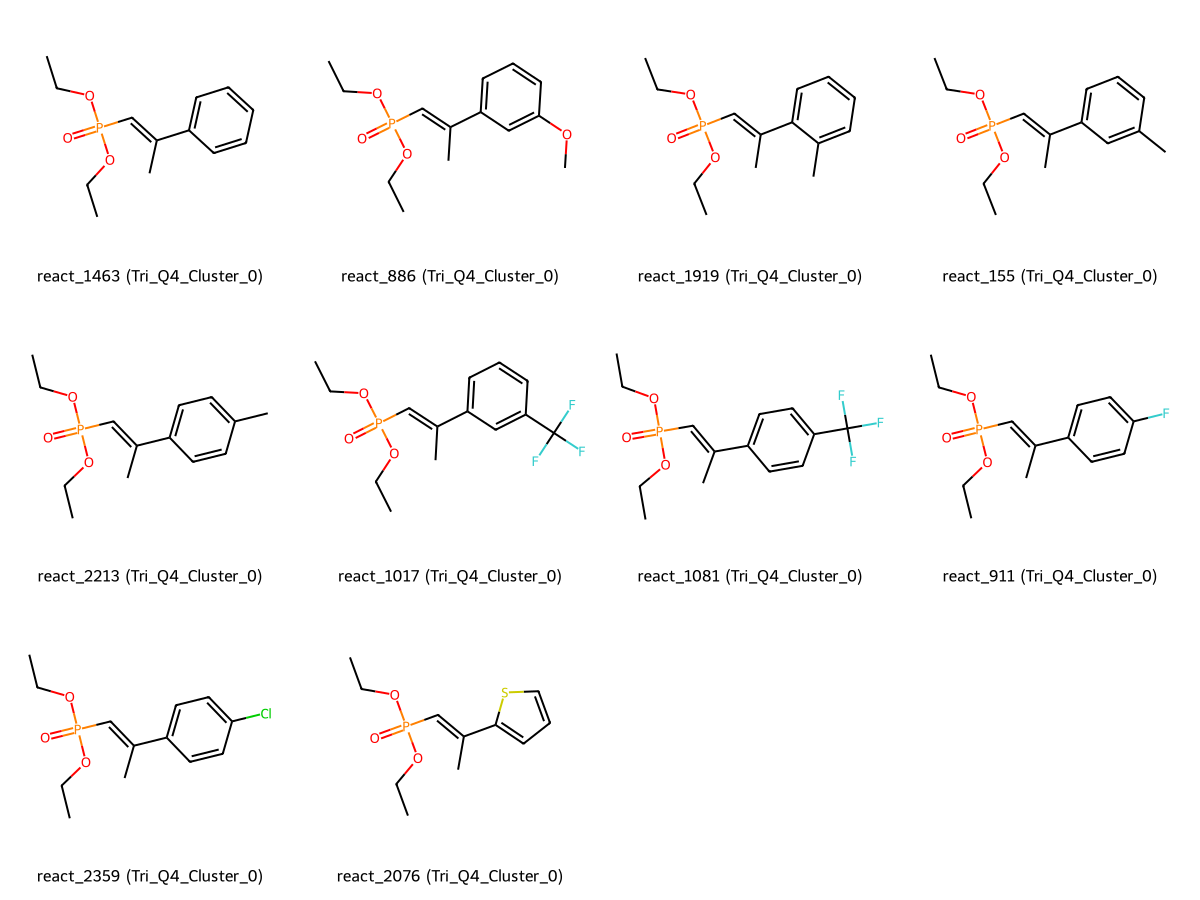

Visualizing group: Tri_Q4_Cluster_1


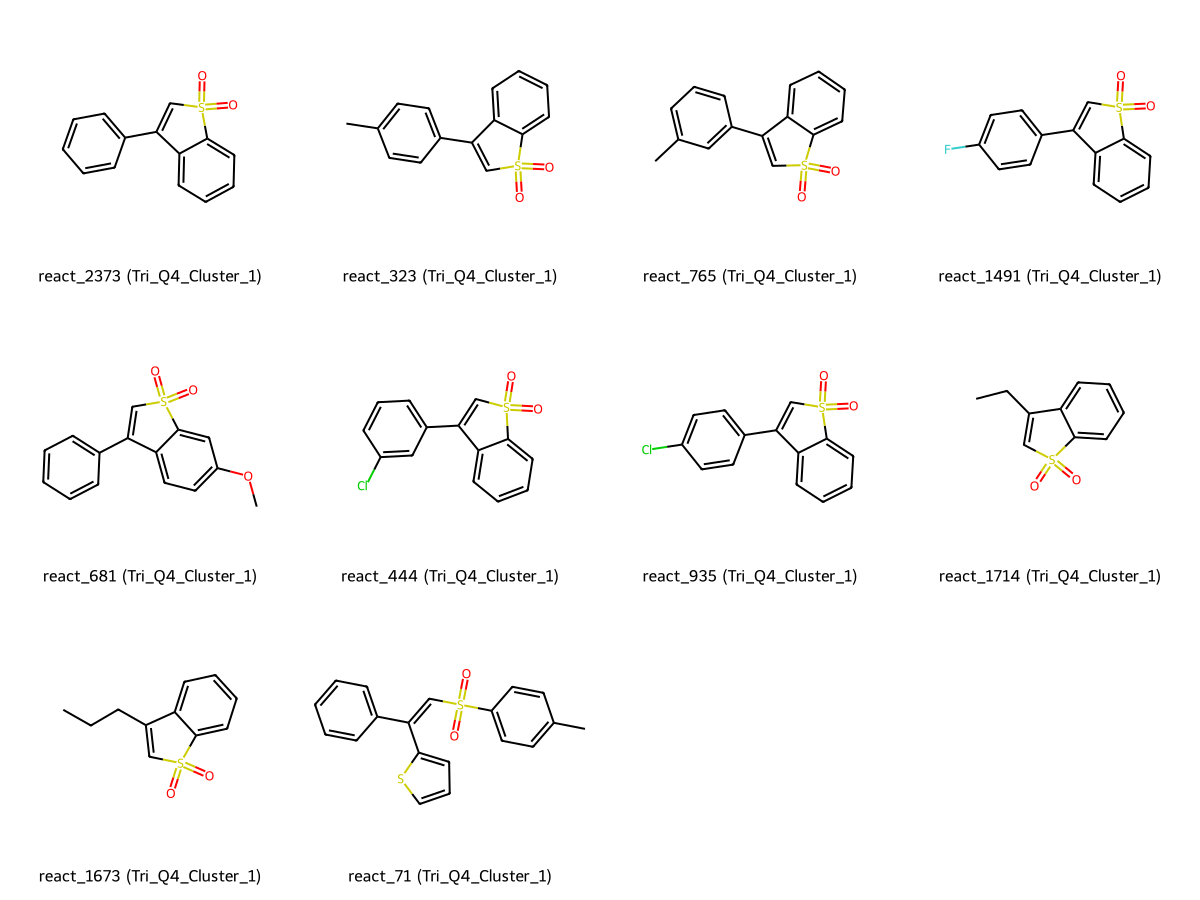

Visualizing group: Tri_Q4_Cluster_2


Visualizing group: Tri_Q4_Cluster_3


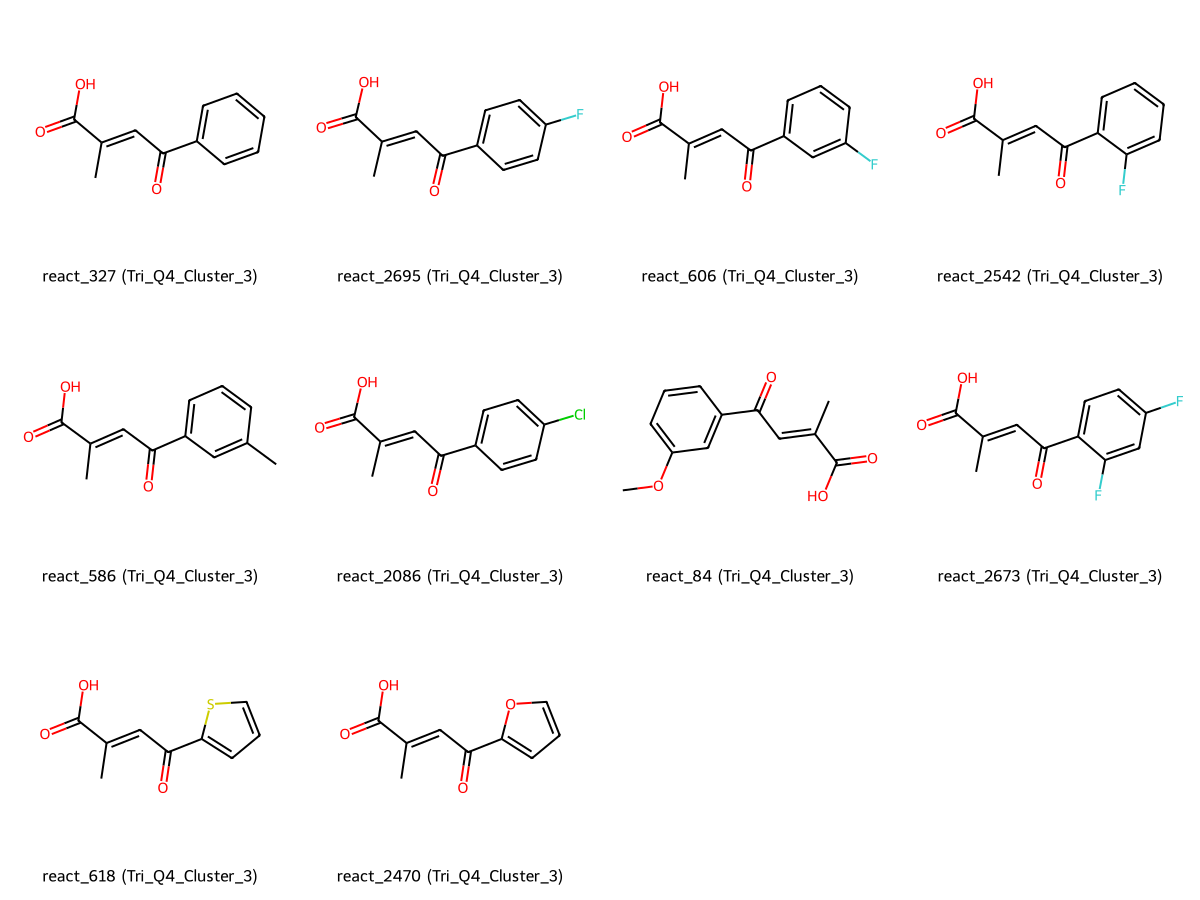

Visualizing group: Tri_Q4_Cluster_4


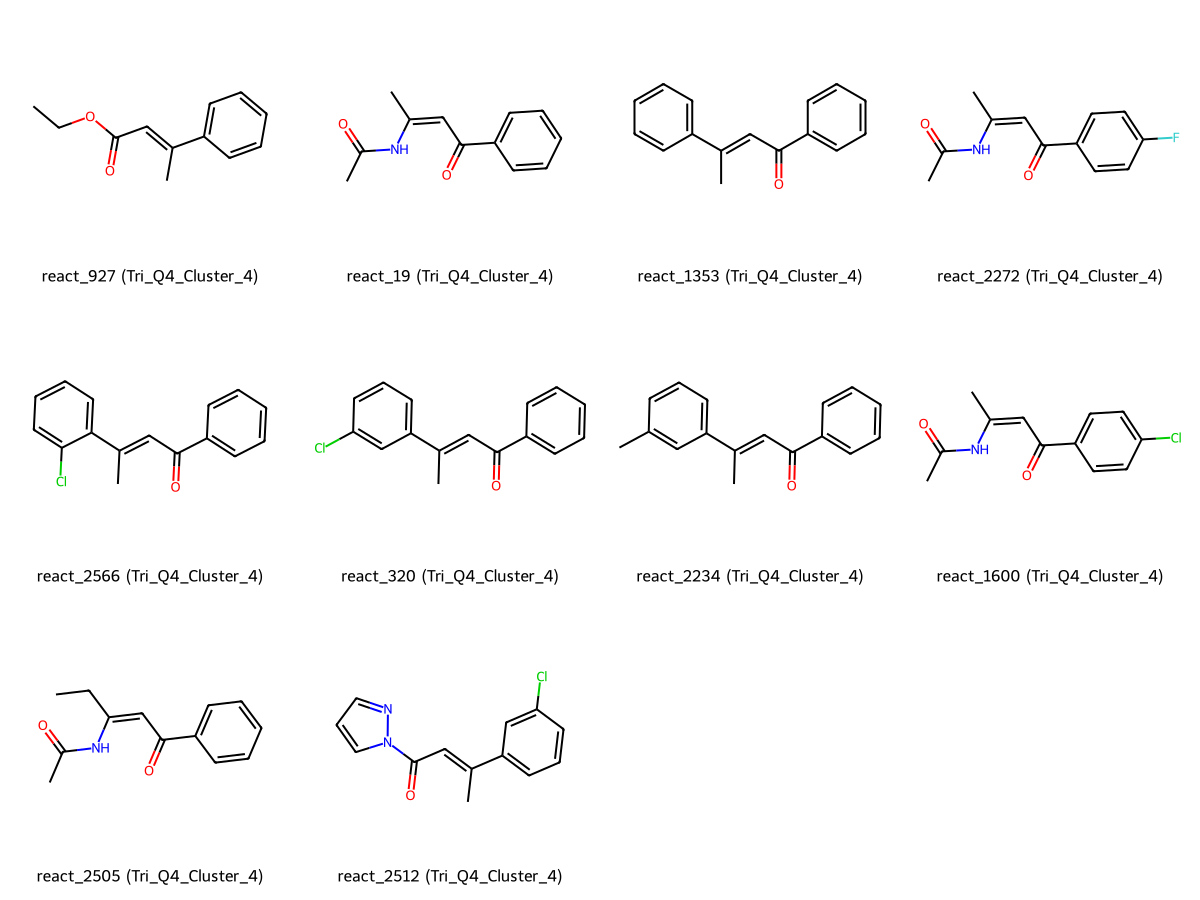

Visualizing group: Tri_Q4_Cluster_5


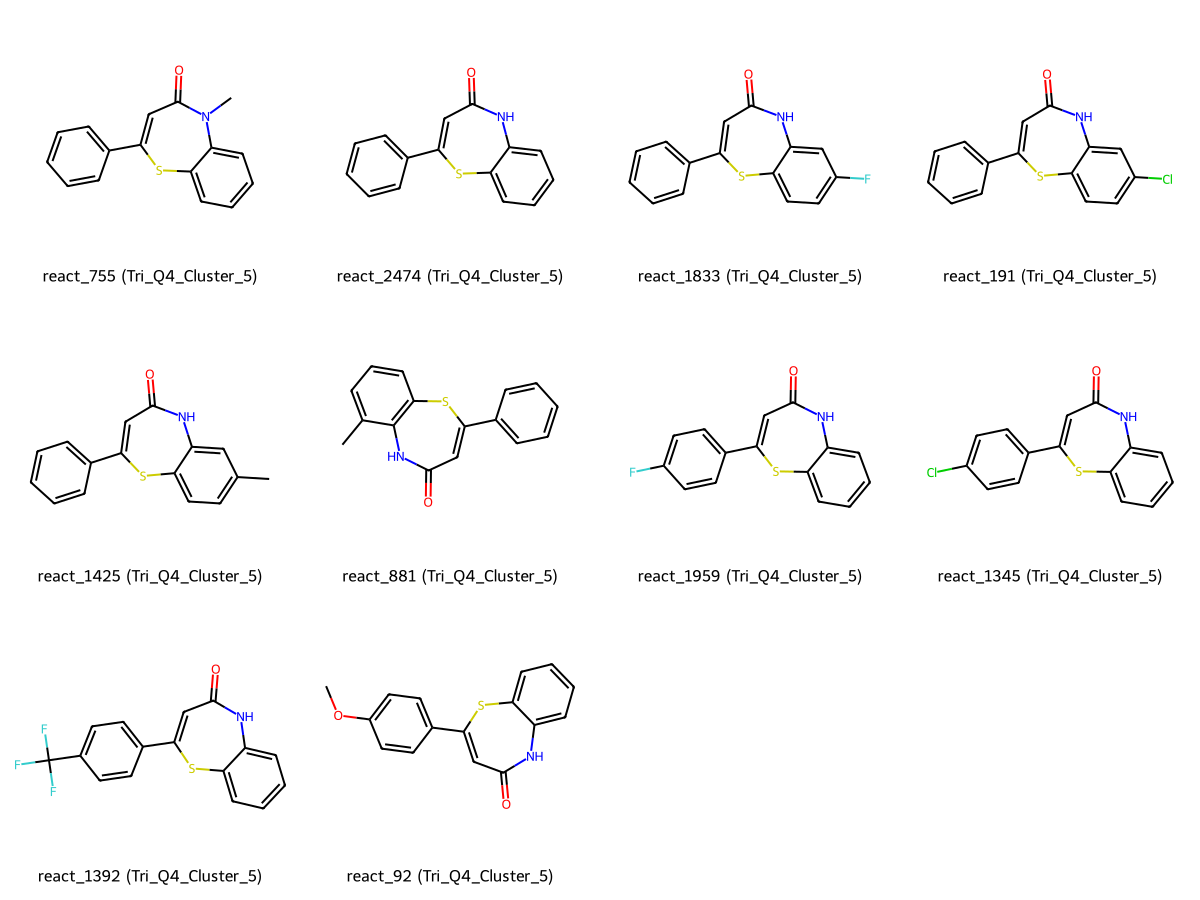

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Load the dataset with Reactant SMILES and IDs
file_path_smiles = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/alkene/fixed_react_map_aho_dataset.xlsx'
df_smiles = pd.read_excel(file_path_smiles)

# Load the dataset for clustering
file_path = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/machine_learning/combined_molecule_data_with_alkene_type.xlsx'
df = pd.read_excel(file_path)

# Print column names to verify their presence
print("Columns in df_smiles:", df_smiles.columns)
print("Columns in df:", df.columns)

# Define the alkene types and their respective cluster numbers
alkene_cluster_map = {
    'Di-sub': 5,
    'Tri_Q2': 7,
    'Tetra': 6,
    'Tri_Q3': 7,
    'Tri_Q4': 6
}

# Function to visualize molecules for a specific group
def visualize_molecules(molecule_ids, group_name):
    # Filter the DataFrame to get rows with the specified Molecule IDs
    if 'Reactant ID' not in df_smiles.columns:
        print(f"Error: 'Reactant ID' column not found in df_smiles.")
        return
    
    # Use Molecule IDs to filter the correct rows
    filtered_df = df_smiles[df_smiles['Reactant ID'].isin(molecule_ids)]

    # Extract unique SMILES strings corresponding to the Reactant IDs
    unique_smiles_df = filtered_df[['Reactant ID', 'Reactant SMILES']].drop_duplicates(subset='Reactant SMILES')

    # Convert SMILES strings to RDKit Mol objects, filtering out any invalid ones
    mols = []
    valid_legends = []
    for index, row in unique_smiles_df.iterrows():
        mol = Chem.MolFromSmiles(row['Reactant SMILES'])
        if mol is not None:  # Only add if the SMILES was valid
            mols.append(mol)
            # Create a label that includes both the Reactant ID and the corresponding alkene type
            legend = f"{row['Reactant ID']} ({group_name})"
            valid_legends.append(legend)

    # Visualize the molecules in a grid with both Reactant ID and alkene type as the legend
    if mols:  # Ensure there are molecules to display
        print(f"Visualizing group: {group_name}")
        img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300, 300), legends=valid_legends)
        display(img)
    else:
        print(f"No valid molecules to display for group: {group_name}")

# Iterate over each alkene type and find the molecules closest to the centroids
for alkene_type, n_clusters in alkene_cluster_map.items():
    print(f"Processing alkene type: {alkene_type} with {n_clusters} clusters")
    
    # Step 1: Filter the DataFrame for the current alkene type
    alkene_df = df[df['_Alkene_Type'] == alkene_type]

    # Ensure 'Molecule' is in the filtered DataFrame
    if 'Molecule' not in alkene_df.columns:
        print(f"Error: 'Molecule' column not found in alkene_df for {alkene_type}.")
        continue

    # Step 2: Select only numeric columns
    df_numeric = alkene_df.select_dtypes(include=[float, int])

    # Drop rows with any missing values
    df_numeric = df_numeric.dropna()

    # Check if there is enough data to proceed
    if df_numeric.empty or len(df_numeric) < n_clusters:
        print(f"Not enough data for clustering for {alkene_type}. Skipping this type.")
        continue

    # Step 3: Apply MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

    # Step 4: Apply KMeans clustering on the scaled data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    alkene_df['Cluster'] = kmeans.fit_predict(df_scaled)

    # Compute the centroids of each cluster
    centroids = kmeans.cluster_centers_

    # Find the molecules closest to each centroid
    distances = cdist(centroids, df_scaled, 'euclidean')

    # For each cluster, find the 10 closest molecules to the centroid
    for cluster_num in range(n_clusters):
        # Get indices of the closest molecules
        closest_indices = np.argsort(distances[cluster_num])[:10]
        closest_molecules = alkene_df.iloc[closest_indices]['Molecule'].values

        # Visualize the closest molecules for this cluster
        visualize_molecules(closest_molecules, f'{alkene_type}_Cluster_{cluster_num}')
